<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/model_4_warming_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install h5py --quiet
!pip -q install "pennylane>=0.42" "pennylane-lightning>=0.42"
# keep thread usage sane on Colab CPU
import os
import torch
os.environ["OMP_NUM_THREADS"] = "2"
torch.set_num_threads(2)

In [2]:
import h5py
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from dataclasses import dataclass, field
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score,precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score)
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
torch.manual_seed(3)
np.random.seed(3)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#  Cell 2: Config
@dataclass
class Config:
    # algo toggles
    TRAIN_PATH: str = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'
    TEST_PATH:  str = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n139306.hdf5'
    Q_MAML_USE: bool = True
    LEARNER_HIDDEN: int = 256
    FREEZE_CNN_DURING_META: bool = True
    W0_SCALE: float = 0.01

    # data / tasking
    SAMPLES: int = 50000
    META_TASK_TYPE: List[str] = field(default_factory=lambda: ['pt', 'm0'])
    META_BIN_COUNT: int = 6
    SUPPORT_SIZE: int = 8
    QUERY_SIZE: int = 8
    MAX_META_TASKS: int = 48

    # model sizes
    NUM_QUBITS: int = 4
    Q_DEPTH: int = 2
    ENCODING_SCHEME: str = 'angle'
    CNN_OUTPUT_DIM: int = 512
    USE_PRETRAINED_CNN: bool = True

    # ---- Task generation knobs ----
    TG_BIN_MODE: str = "quantile"
    TG_TARGET_JSD_MAX: float = 0.45     # relaxed weighted JSD
    TG_JSD_MAX_TRIES: int = 24
    TG_NUM_TASKS_PER_BIN: int = 6
    TG_TRAIN_SEED: int = 42
    TG_TEST_SEED: int  = 43

    # per-feature soft caps (baseline)
    TG_CAP_PT: float = 0.65
    TG_CAP_M0: float = 0.60

    # logistic AUC guard on (pt,m0) trained on support, eval on query
    GUARD_LOGREG_AUC_MIN: float = 0.58

    # --- PCA guard ---
    PCA_COMPONENTS: int = 128
    PCA_GUARD_CAL_TRIALS: int = 60
    PCA_GUARD_PERCENTILE: float = 0.60
    PCA_GUARD_CLAMP_MIN: float = 0.56
    PCA_GUARD_CLAMP_MAX: float = 0.90

    # --- Warm-up / adaptive gates ---
    WARMUP_ACCEPT_N: int = 24            # first N accepted tasks per split use warm threshold
    WARMUP_PCA_DELTA: float = 0.03       # threshold -= this during warmup (min 0.52)
    ADAPTIVE_M0_LOOSE_CAP: float = 0.50  # temporary m0 cap until a few tasks in a bin
    ADAPTIVE_M0_MIN_ACCEPT: int = 3      # once bin has >= this, use strict cap (0.35)

    # training
    USE_ANALYTIC_GRADIENTS: bool = True
    INNER_STEPS: int = 8       # fewer adaptation steps
    INNER_LR: float = 0.01     # smaller step size
    META_BIN_COUNT: int = 4
    MAX_META_TASKS: int = 100
    INNER_STEPS: int = 12
    INNER_LR: float = 0.02
    OUTER_LR: float = 5e-3
    EPOCHS: int = 15
    BATCH_SIZE: int = 24
    EVAL_METRICS: bool = True
    SAVE_BEST_MODEL: bool = True

    # io
    PRETRAIN_QMAML: bool = True
    USE_QMAML_PRETRAINED_INIT: bool = True
    QMAML_INIT_TAG: str = "qmaml_init"
    CHECKPOINT_DIR: str = '/content/drive/MyDrive/quark-gluon-checkpoints'

config = Config()
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)


In [5]:
# Utility: total L2 grad norm for one or more parameter groups
def _total_grad_norm(*param_groups) -> float:
    sq = 0.0
    for group in param_groups:
        for p in group:
            if (p.grad is not None) and torch.isfinite(p.grad).all():
                g = float(p.grad.detach().norm(2).item())
                sq += g * g
    return sq ** 0.5


In [6]:
# CELL 2 — Dataset + Normalization

class JetDataset(torch.utils.data.Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, pt: np.ndarray, m0: np.ndarray):
        self.X  = X.astype(np.float32, copy=False)    # (N,H,W,C)
        self.y  = y.astype(np.int64,   copy=False)    # (N,)
        self.pt = pt.astype(np.float32, copy=False)
        self.m0 = m0.astype(np.float32, copy=False)

    def __len__(self) -> int: return len(self.y)
    def __getitem__(self, idx: int): return self.X[idx], int(self.y[idx])

def _describe_dataset(name: str, ds: JetDataset):
    N = len(ds)
    yc = np.bincount(ds.y, minlength=2)
    print(f"[{name}] N={N}  y-counts={yc.tolist()}  frac(class1)={yc[1]/max(1,yc.sum()):.3f}")
    for feat in ("pt","m0"):
        a = getattr(ds, feat)
        print(f"  {feat}: min={a.min():.3f} p10={np.percentile(a,10):.3f} "
              f"p50={np.percentile(a,50):.3f} p90={np.percentile(a,90):.3f} max={a.max():.3f}")
    Xs = ds.X[:5]
    print(f"  X sample: shape={Xs.shape}, dtype={Xs.dtype}, min={Xs.min():.3f}, max={Xs.max():.3f}")

def load_datasets(cfg: Config) -> Tuple[JetDataset, JetDataset]:
    def _load(path: str, take: int) -> JetDataset:
        with h5py.File(path, 'r') as f:
            X  = f['X_jets'][:take]
            y  = f['y'][:take]
            pt = f['pt'][:take]
            m0 = f['m0'][:take]
        return JetDataset(X, y, pt, m0)
    train = _load(cfg.TRAIN_PATH, cfg.SAMPLES)
    test  = _load(cfg.TEST_PATH,  cfg.SAMPLES)
    _describe_dataset("TRAIN(raw)", train)
    _describe_dataset("TEST(raw)",  test)
    return train, test

train_dataset, test_dataset = load_datasets(config)

# Train-only per-channel normalization (applied to both splits)
GLOBAL_NORM = {
    "mean": train_dataset.X.mean(axis=(0,1,2), keepdims=True),
    "std":  train_dataset.X.std(axis=(0,1,2),  keepdims=True) + 1e-6
}

def normalize_images(x: np.ndarray) -> np.ndarray:
    return (x - GLOBAL_NORM["mean"]) / GLOBAL_NORM["std"]

print("\n[Norm] per-channel mean/std computed on TRAIN and applied to both splits.")

[TRAIN(raw)] N=50000  y-counts=[25001, 24999]  frac(class1)=0.500
  pt: min=70.233 p10=88.928 p50=111.417 p90=152.465 max=308.844
  m0: min=2.736 p10=13.973 p50=20.253 p90=29.440 max=78.605
  X sample: shape=(5, 125, 125, 3), dtype=float32, min=0.000, max=0.439
[TEST(raw)] N=50000  y-counts=[24981, 25019]  frac(class1)=0.500
  pt: min=70.398 p10=88.809 p50=111.321 p90=152.452 max=337.052
  m0: min=3.672 p10=13.969 p50=20.239 p90=29.332 max=71.282
  X sample: shape=(5, 125, 125, 3), dtype=float32, min=0.000, max=0.587

[Norm] per-channel mean/std computed on TRAIN and applied to both splits.


In [7]:
# CELL 3 — PCA extractor + calibration (consistent with normalization)

from sklearn.preprocessing import StandardScaler

class PCAFeatureExtractor:
    """PCA fitted on normalized images; transform expects normalized inputs (same pipeline)."""
    def __init__(self, n_components: int):
        self.n = int(n_components)
        self.scaler = StandardScaler(with_mean=True, with_std=True)
        self.pca = PCA(n_components=self.n, svd_solver="randomized", whiten=False, random_state=42)
        self.fitted = False

    def fit_from_dataset(self, ds, max_samples: int = 15000, rng_seed: int = 42):
        rng = np.random.default_rng(rng_seed)
        N = len(ds.y); k = min(max_samples, N)
        idx = rng.choice(np.arange(N), size=k, replace=False)
        X = ds.X[idx]                        # NHWC
        X = normalize_images(X)              # <-- IMPORTANT: fit on normalized images
        X = X.reshape(X.shape[0], -1)
        Xs = self.scaler.fit_transform(X)
        self.pca.fit(Xs)
        self.fitted = True
        return self

    def embed(self, x_bchw: torch.Tensor) -> torch.Tensor:
        """Return PCA features as float32 torch tensor (B, n_components)."""
        assert self.fitted, "PCA not fitted; call fit_from_dataset first."
        if x_bchw.dim() == 4:  # (B,C,H,W)
            B = x_bchw.shape[0]
            x = (
                x_bchw.detach()
                .permute(0, 2, 3, 1)
                .contiguous()
                .view(B, -1)
                .cpu()
                .numpy()
            )
        elif x_bchw.dim() == 3:  # (C,H,W)
            x = (
                x_bchw.detach()
                .permute(1, 2, 0)
                .contiguous()
                .view(1, -1)
                .cpu()
                .numpy()
            )
        else:
            raise ValueError("Expected BCHW or CHW tensor.")
        xs = self.scaler.transform(x)
        z = self.pca.transform(xs)
        return torch.from_numpy(z.astype(np.float32))

# Light PCA (for the guard) on normalized images
pca_guard_extractor = PCAFeatureExtractor(n_components=config.PCA_COMPONENTS).fit_from_dataset(train_dataset, max_samples=30000)

@torch.no_grad()
def _proto_acc_pca_cos(Xs_n: np.ndarray, ys: np.ndarray, Xq_n: np.ndarray, yq: np.ndarray) -> float:
    def to_t(x):  # (N,H,W,C) -> (N,C,H,W)
        return torch.from_numpy(x.transpose(0,3,1,2).copy()).float()
    Fs = pca_guard_extractor.embed(to_t(Xs_n))
    Fq = pca_guard_extractor.embed(to_t(Xq_n))
    mu_s = Fs.mean(0, keepdim=True); sd_s = Fs.std(0, keepdim=True).clamp_min(1e-6)
    Fs = (Fs - mu_s) / sd_s; Fq = (Fq - mu_s) / sd_s
    m0 = Fs[torch.from_numpy(ys)==0].mean(0, keepdim=True)
    m1 = Fs[torch.from_numpy(ys)==1].mean(0, keepdim=True)
    def _n(u): return u / u.norm(dim=1, keepdim=True).clamp_min(1e-6)
    d0 = 1 - (_n(Fq) @ _n(m0).T)
    d1 = 1 - (_n(Fq) @ _n(m1).T)
    pred = (d1 < d0).long().squeeze(1).cpu().numpy()
    return float((pred == yq).mean())

def _calibrate_pca_guard(ds: JetDataset, support_size=8, query_size=8,
                         trials=60, seed=7) -> float:
    rng = np.random.default_rng(seed)
    accs=[]
    for _ in range(trials):
        idx0 = np.where(ds.y==0)[0]
        idx1 = np.where(ds.y==1)[0]
        s0 = rng.choice(idx0, support_size//2, replace=False)
        s1 = rng.choice(idx1, support_size//2, replace=False)
        q0 = rng.choice(np.setdiff1d(idx0, s0), query_size//2, replace=False)
        q1 = rng.choice(np.setdiff1d(idx1, s1), query_size//2, replace=False)
        s_idx = np.concatenate([s0,s1]); q_idx = np.concatenate([q0,q1])
        Xs_n = normalize_images(ds.X[s_idx]); Xq_n = normalize_images(ds.X[q_idx])
        ys = ds.y[s_idx]; yq = ds.y[q_idx]
        accs.append(_proto_acc_pca_cos(Xs_n, ys, Xq_n, yq))
    raw = float(np.quantile(accs, config.PCA_GUARD_PERCENTILE))
    thr = float(np.clip(raw, config.PCA_GUARD_CLAMP_MIN, config.PCA_GUARD_CLAMP_MAX))
    print(f"[PCA guard] raw q={config.PCA_GUARD_PERCENTILE:.0%}: {raw:.3f}  -> clamped: {thr:.3f} "
          f"(mean={np.mean(accs):.3f}, min={np.min(accs):.3f}, max={np.max(accs):.3f})")
    return thr

PCA_GUARD_THRESHOLD = _calibrate_pca_guard(train_dataset,
                                           support_size=config.SUPPORT_SIZE,
                                           query_size=config.QUERY_SIZE,
                                           trials=config.PCA_GUARD_CAL_TRIALS)


[PCA guard] raw q=60%: 0.550  -> clamped: 0.560 (mean=0.537, min=0.125, max=0.875)


In [8]:
# CELL 4 — Helpers (JS/edges/etc.)

def _gather_h5safe(arr: np.ndarray, idx: np.ndarray) -> np.ndarray:
    idx = np.asarray(idx).reshape(-1)
    order = np.argsort(idx)
    inv = np.empty_like(order); inv[order] = np.arange(order.size)
    return arr[idx[order]][inv]

def _hist_jsd(a: np.ndarray, b: np.ndarray, bins: int = 24) -> float:
    if a.size == 0 or b.size == 0: return np.nan
    lo, hi = float(min(a.min(), b.min())), float(max(a.max(), b.max()))
    if not np.isfinite([lo,hi]).all() or lo >= hi: return 0.0
    pa, edges = np.histogram(a, bins=bins, range=(lo,hi), density=True)
    pb, _     = np.histogram(b, bins=edges, density=True)
    pa = (pa + 1e-12); pb = (pb + 1e-12)
    pa /= pa.sum(); pb /= pb.sum()
    m = 0.5*(pa+pb)
    return 0.5*(np.sum(pa*np.log(pa/m)) + np.sum(pb*np.log(pb/m)))

def _quantile_edges(x: np.ndarray, bin_count: int) -> np.ndarray:
    qs = np.linspace(0, 1, bin_count+1)
    edges = np.quantile(x, qs).astype(np.float64)
    for i in range(1, edges.size):
        if edges[i] <= edges[i-1]:
            edges[i] = np.nextafter(edges[i-1], np.inf)
    return edges

def _choose_query_joint_match(rem_idx: np.ndarray,
                              anchor_pt: np.ndarray, anchor_m0: np.ndarray,
                              k: int, pt_all: np.ndarray, m0_all: np.ndarray,
                              rng: np.random.Generator) -> np.ndarray:
    if rem_idx.size <= k: return rem_idx.copy()
    qs = np.linspace(0,1,k+2)[1:-1]
    tgt_pt = np.quantile(anchor_pt, qs); tgt_m0 = np.quantile(anchor_m0, qs)
    mu_pt, sd_pt = float(np.mean(anchor_pt)), float(np.std(anchor_pt)+1e-6)
    mu_m0, sd_m0 = float(np.mean(anchor_m0)), float(np.std(anchor_m0)+1e-6)
    R = rem_idx.copy()
    z_pt = (pt_all[R] - mu_pt)/sd_pt; z_m0 = (m0_all[R] - mu_m0)/sd_m0
    chosen=[]; used = np.zeros(R.size, dtype=bool)
    for tp, tm in zip(tgt_pt, tgt_m0):
        tpz = (tp - mu_pt)/sd_pt; tmz = (tm - mu_m0)/sd_m0
        d = np.abs(z_pt - tpz) + np.abs(z_m0 - tmz)
        d[used] = np.inf
        j = int(np.argmin(d)); used[j] = True
        chosen.append(R[j])
    if len(chosen) < k:
        d = np.abs(z_pt) + np.abs(z_m0); d[used] = np.inf
        order = np.argsort(d); need = k - len(chosen)
        chosen.extend(list(R[order[:need]]))
    return np.asarray(chosen[:k])

def _logreg_auc_guard(pt_s, m0_s, y_s, pt_q, m0_q, y_q, lam=1e-2, iters=6) -> float:
    def _std2(a):
        mu, sd = a.mean(0, keepdims=True), a.std(0, keepdims=True)
        sd = np.clip(sd, 1e-6, None)
        return (a - mu) / sd, mu, sd
    Xs = np.stack([pt_s, m0_s], 1); Xq = np.stack([pt_q, m0_q], 1)
    Xs, mu, sd = _std2(Xs); Xq = (Xq - mu) / sd
    y = y_s.astype(np.float64).reshape(-1,1)
    X = np.concatenate([np.ones((Xs.shape[0],1)), Xs], 1)
    w = np.zeros((X.shape[1],1), dtype=np.float64)
    for _ in range(iters):
        z = X @ w; p = 1.0 / (1.0 + np.exp(-np.clip(z, -20, 20)))
        g = X.T @ (p - y) + lam * np.r_[np.zeros((1,1)), w[1:]]
        S = (p*(1-p)).flatten(); H = X.T @ (X * S[:,None]); H[1:,1:] += lam * np.eye(H.shape[0]-1)
        try: step = np.linalg.solve(H, g)
        except np.linalg.LinAlgError: step = np.linalg.lstsq(H, g, rcond=None)[0]
        w -= step
    pq = 1.0 / (1.0 + np.exp(-np.clip(np.c_[np.ones((Xq.shape[0],1)), Xq] @ w, -20, 20)))
    auc = roc_auc_score(y_q, pq.ravel())
    return float(max(auc, 1.0-auc))  # orientation-agnostic

def _zscore_arr(a: np.ndarray) -> np.ndarray:
    mu, sd = np.mean(a), np.std(a); return (a - mu) / max(sd, 1e-6)

def _build_score(pt: np.ndarray, m0: np.ndarray) -> np.ndarray:
    zp, zm = _zscore_arr(pt), _zscore_arr(m0)
    return (1.0 * zm) + (-0.35 * zp)


In [9]:
# CELL 5 — MAIN: generate_meta_tasks  (with adaptive m0 cap + warm-up PCA guard)

def generate_meta_tasks(
    dataset: "Dataset",
    meta_task_types: List[str],
    bin_count: int,
    support_size: int,
    query_size: int,
    num_tasks_per_bin: int = 4,
    max_tasks: int = 128,
    seed: int = 42,
    bin_mode: str = "quantile",
    align_mode: str = "quantile_match",
    target_jsd_max: float = 0.30,
    jsd_max_tries: int = 12,
) -> List[Dict[str, Any]]:
    """
    Minimal logic changes:
      • Supports from class-conditional tails of score = z(m0) - 0.35*z(pt)
      • Weighted JSD with m0 emphasis (w_pt=0.3, w_m0=0.7)
      • Adaptive m0 cap: loose until ADAPTIVE_M0_MIN_ACCEPT tasks in a bin
      • Warm-up PCA guard: slightly lower threshold for first WARMUP_ACCEPT_N accepted tasks
    """
    rng = np.random.default_rng(seed)
    X, y = dataset.X, dataset.y
    pt = getattr(dataset, "pt"); m0 = getattr(dataset, "m0")
    assert support_size % 2 == 0 and query_size % 2 == 0
    half_s, half_q = support_size // 2, query_size // 2
    need_per_class = half_s + half_q

    score = _build_score(pt, m0)
    w_pt, w_m0 = 0.30, 0.70

    metas: List[Dict[str, Any]] = []
    total = 0
    accepted_total = 0
    accepted_count: Dict[Tuple[str,int], int] = {}

    def _edges_for(a: np.ndarray) -> np.ndarray:
        return _quantile_edges(a, bin_count)

    def _sample_support_from_tails(c_idx: np.ndarray, label: int) -> np.ndarray:
        if c_idx.size < half_s: return np.array([], dtype=int)
        svals = score[c_idx]; order = np.argsort(svals)
        tail_frac = 0.25; k_tail = max(int(np.ceil(tail_frac * c_idx.size)), half_s + 2)
        if label == 0: pool = c_idx[order][-k_tail:]
        else:          pool = c_idx[order][: k_tail]
        if pool.size < half_s: pool = c_idx
        return rng.choice(pool, size=half_s, replace=False)

    for feature_type in meta_task_types:
        active = getattr(dataset, feature_type)
        edges = _edges_for(active)

        for b in range(edges.size - 1):
            lo, hi = edges[b], edges[b + 1]
            mask = (active >= lo) & (active <= hi if b == edges.size - 2 else active < hi)
            idx = np.where(mask)[0]
            if idx.size < support_size + query_size: continue
            c0 = idx[y[idx] == 0]; c1 = idx[y[idx] == 1]
            if (c0.size < need_per_class) or (c1.size < need_per_class): continue

            max_here = min(num_tasks_per_bin,
                           int(len(c0) // (half_s + half_q)),
                           int(len(c1) // (half_s + half_q)))
            if max_here <= 0: continue

            for _ in range(max_here):
                if (c0.size < need_per_class) or (c1.size < need_per_class): break

                s0 = _sample_support_from_tails(c0, label=0)
                s1 = _sample_support_from_tails(c1, label=1)
                rem0 = np.setdiff1d(c0, s0, assume_unique=False)
                rem1 = np.setdiff1d(c1, s1, assume_unique=False)
                if (s0.size < half_s) or (s1.size < half_s) or (rem0.size < half_q) or (rem1.size < half_q): break

                q0 = _choose_query_joint_match(rem0, pt[s0], m0[s0], half_q, pt, m0, rng)
                q1 = _choose_query_joint_match(rem1, pt[s1], m0[s1], half_q, pt, m0, rng)

                tries, accepted = 0, False
                while tries < jsd_max_tries:
                    tries += 1
                    s_idx = np.concatenate([s0, s1]); q_idx = np.concatenate([q0, q1])

                    jsd_pt = _hist_jsd(pt[s_idx], pt[q_idx], bins=24)
                    jsd_m0 = _hist_jsd(m0[s_idx], m0[q_idx], bins=24)
                    wjsd   = w_pt * jsd_pt + w_m0 * jsd_m0

                    # adaptive m0 cap (looser until a few accepted in this bin)
                    key = (feature_type, int(b))
                    cap_m0_eff = (config.ADAPTIVE_M0_LOOSE_CAP
                                  if accepted_count.get(key, 0) < config.ADAPTIVE_M0_MIN_ACCEPT
                                  else 0.35)
                    cap_pt_eff = config.TG_CAP_PT

                    if not (np.isfinite(wjsd) and wjsd <= target_jsd_max and
                            (not np.isfinite(jsd_pt) or jsd_pt <= cap_pt_eff) and
                            (not np.isfinite(jsd_m0) or jsd_m0 <= cap_m0_eff)):
                        # try re-matching queries then re-pick supports from tails
                        if tries % 2 == 1:
                            q0 = _choose_query_joint_match(rem0, pt[s0], m0[s0], half_q, pt, m0, rng)
                            q1 = _choose_query_joint_match(rem1, pt[s1], m0[s1], half_q, pt, m0, rng)
                        else:
                            s0 = _sample_support_from_tails(c0, 0); s1 = _sample_support_from_tails(c1, 1)
                            rem0 = np.setdiff1d(c0, s0, assume_unique=False)
                            rem1 = np.setdiff1d(c1, s1, assume_unique=False)
                            if (rem0.size < half_q) or (rem1.size < half_q): break
                            q0 = _choose_query_joint_match(rem0, pt[s0], m0[s0], half_q, pt, m0, rng)
                            q1 = _choose_query_joint_match(rem1, pt[s1], m0[s1], half_q, pt, m0, rng)
                        continue

                    auc = _logreg_auc_guard(pt[s0], m0[s0], y[s0], pt[q_idx], m0[q_idx], y[q_idx])
                    if auc < config.GUARD_LOGREG_AUC_MIN:
                        s0 = _sample_support_from_tails(c0, 0); s1 = _sample_support_from_tails(c1, 1)
                        rem0 = np.setdiff1d(c0, s0, assume_unique=False)
                        rem1 = np.setdiff1d(c1, s1, assume_unique=False)
                        if (rem0.size < half_q) or (rem1.size < half_q): break
                        q0 = _choose_query_joint_match(rem0, pt[s0], m0[s0], half_q, pt, m0, rng)
                        q1 = _choose_query_joint_match(rem1, pt[s1], m0[s1], half_q, pt, m0, rng)
                        continue

                    # PCA guard warm-up (normalize only for guard; store RAW for CNN)
                    Xs_raw = _gather_h5safe(X, s_idx)
                    Xq_raw = _gather_h5safe(X, q_idx)
                    Xs_n = normalize_images(Xs_raw)
                    Xq_n = normalize_images(Xq_raw)
                    acc_img = _proto_acc_pca_cos(Xs_n, y[s_idx], Xq_n, y[q_idx])
                    thr_base = PCA_GUARD_THRESHOLD
                    thr_warm = max(0.52, PCA_GUARD_THRESHOLD - config.WARMUP_PCA_DELTA)
                    thr_use  = thr_warm if accepted_total < config.WARMUP_ACCEPT_N else thr_base

                    if (acc_img >= thr_use) and (acc_img <= config.PCA_GUARD_CLAMP_MAX):
                        accepted = True
                        break
                    else:
                        if tries % 2 == 1:
                            q0 = _choose_query_joint_match(rem0, pt[s0], m0[s0], half_q, pt, m0, rng)
                            q1 = _choose_query_joint_match(rem1, pt[s1], m0[s1], half_q, pt, m0, rng)
                        else:
                            s0 = _sample_support_from_tails(c0, 0); s1 = _sample_support_from_tails(c1, 1)
                            rem0 = np.setdiff1d(c0, s0, assume_unique=False)
                            rem1 = np.setdiff1d(c1, s1, assume_unique=False)
                            if (rem0.size < half_q) or (rem1.size < half_q): break
                            q0 = _choose_query_joint_match(rem0, pt[s0], m0[s0], half_q, pt, m0, rng)
                            q1 = _choose_query_joint_match(rem1, pt[s1], m0[s1], half_q, pt, m0, rng)

                if not accepted:
                    continue

                sX = torch.from_numpy(Xs_raw.transpose(0,3,1,2).copy()).float().contiguous()
                qX = torch.from_numpy(Xq_raw.transpose(0,3,1,2).copy()).float().contiguous()
                sy = torch.from_numpy(y[s_idx]).long()
                qy = torch.from_numpy(y[q_idx]).long()

                metas.append({
                    "support_X": sX, "support_y": sy,
                    "query_X":   qX, "query_y":   qy,
                    "support_idx": s_idx, "query_idx": q_idx,
                    "feature_tag": feature_type, "bin_id": int(b)
                })
                total += 1; accepted_total += 1
                accepted_count[key] = accepted_count.get(key, 0) + 1

                # light depletion to control reuse
                c0 = np.setdiff1d(c0, np.concatenate([s0, q0]), assume_unique=False)
                c1 = np.setdiff1d(c1, np.concatenate([s1, q1]), assume_unique=False)

                if total >= max_tasks:
                    print(f"Total meta-tasks generated: {total}")
                    print(f"Total meta-tasks actually sending: {len(metas)}")
                    return metas

    print(f"Total meta-tasks generated: {total}")
    print(f"Total meta-tasks actually sending: {len(metas)}")
    return metas


meta_task_types = config.META_TASK_TYPE

meta_tasks = generate_meta_tasks(
    train_dataset,
    meta_task_types=meta_task_types,
    bin_count=config.META_BIN_COUNT,
    support_size=config.SUPPORT_SIZE,
    query_size=config.QUERY_SIZE,
    num_tasks_per_bin=config.TG_NUM_TASKS_PER_BIN,
    max_tasks=config.MAX_META_TASKS,
    seed=config.TG_TRAIN_SEED,
    target_jsd_max=config.TG_TARGET_JSD_MAX,
    jsd_max_tries=config.TG_JSD_MAX_TRIES,
)

test_meta_tasks = generate_meta_tasks(
    test_dataset,
    meta_task_types=meta_task_types,
    bin_count=config.META_BIN_COUNT,
    support_size=config.SUPPORT_SIZE,
    query_size=config.QUERY_SIZE,
    num_tasks_per_bin=config.TG_NUM_TASKS_PER_BIN,
    max_tasks=min(96, config.MAX_META_TASKS),
    seed=config.TG_TEST_SEED,
    target_jsd_max=config.TG_TARGET_JSD_MAX,
    jsd_max_tries=config.TG_JSD_MAX_TRIES,
)


Total meta-tasks generated: 28
Total meta-tasks actually sending: 28
Total meta-tasks generated: 29
Total meta-tasks actually sending: 29


In [10]:
for split_name, tasks in [("train(meta_tasks)", meta_tasks), ("test(test_meta_tasks)", test_meta_tasks)]:
    yq = torch.cat([t["query_y"] for t in tasks]).cpu().numpy()
    yc = np.bincount(yq, minlength=2)
    print(f"[Probe 7E] {split_name} query class counts:", yc, " -> ratio:", yc[1] / max(1, yc.sum()))

[Probe 7E] train(meta_tasks) query class counts: [112 112]  -> ratio: 0.5
[Probe 7E] test(test_meta_tasks) query class counts: [116 116]  -> ratio: 0.5


In [11]:
# --- Cell 5: CNN Feature Extractor ---

class CNNFeatureExtractor(nn.Module):
    """
    ResNet18 with small-stem and split head:
    - embed(x) -> 512-D feature (stable for tasks)
    - forward(x) -> num_qubits angles (fed to PQC)
    """
    def __init__(self, output_dim: int, num_qubits: int):
        super().__init__()
        m = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        # small-stem for 125x125
        m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        m.maxpool = nn.Identity()
        self.backbone = m

        # shared projector to a stable embedding
        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, output_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        # map embedding -> angles
        self.to_angles = nn.Linear(output_dim, num_qubits)

        # ImageNet normalization
        self.register_buffer("_mean", torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.register_buffer("_std",  torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))

    def _norm(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3: x = x.unsqueeze(0)
        x = x.float()
        m, s = float(x.mean()), float(x.std())
        if x.max() > 1.5 and not (abs(m) < 0.1 and 0.6 < s < 1.5):
            x = x / 255.0
        return (x - self._mean.to(x)) / self._std.to(x)

    @torch.no_grad()
    def embed(self, x: torch.Tensor) -> torch.Tensor:
        """Return 512-D embedding (no angle mapping)."""
        x = self._norm(x)
        self.backbone.eval()
        return self.backbone(x)  # (B, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._norm(x)
        feat = self.backbone(x)       # (B, output_dim)
        angles = self.to_angles(feat) # (B, num_qubits)
        return angles


cnn_extractor = CNNFeatureExtractor(config.CNN_OUTPUT_DIM, config.NUM_QUBITS)
def freeze_bn(m: nn.Module) -> None:
    for mod in m.modules():
        if isinstance(mod, nn.BatchNorm2d):
            mod.eval()
            for p in mod.parameters(): p.requires_grad = False

def set_cnn_trainable(cnn, train_layer4=True, train_to_angles=True):
    """
    Freeze everything in the ResNet backbone, then explicitly unfreeze:
      • layer4 (convs only; keep BN frozen)
      • to_angles head
    BN layers stay in eval mode with requires_grad=False.
    """
    # 1) freeze everything
    for p in cnn.backbone.parameters():
        p.requires_grad = False

    # 2) unfreeze layer4 CONVs (keep BN frozen)
    if train_layer4:
        for name, p in cnn.backbone.named_parameters():
            if "layer4" in name and "bn" not in name:  # don't unfreeze BN params
                p.requires_grad = True

    # 3) to_angles head
    for p in cnn.to_angles.parameters():
        p.requires_grad = bool(train_to_angles)

    # 4) keep all BN in eval mode + frozen
    freeze_bn(cnn)  # your existing helper (sets .eval() and requires_grad=False on BN)


def freeze_cnn_except_last_block(cnn):
    for name, param in cnn.backbone.named_parameters():
        if "layer4" not in name:
            param.requires_grad = False


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [12]:
# --- Cell 6: PQC Model ---
class PQCModel(nn.Module):
    """
    PennyLane QNode wrapper with angle encoding and StronglyEntanglingLayers.
    Uses lightning.qubit + adjoint on CPU when available (fast), otherwise falls
    back to default.qubit + parameter-shift. Supports QMAML via weights_override.
    Multi-qubit readout: returns expvals for all wires, then a linear head -> 2 logits.
    """
    def __init__(
        self,
        num_qubits: int,
        depth: int,
        init_type: str = "qmaml",
        use_lightning: bool = True,
        bound_angles: bool = False,   # if True, tanh-bound inputs to (-pi, pi) for stability
        verbose: bool = False,
    ):
        super().__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.bound_angles = bound_angles

        _diff_method = "parameter-shift"
        if use_lightning:
            try:
                self.dev = qml.device("lightning.qubit", wires=num_qubits)
                _diff_method = "adjoint"
                if verbose: print("[PQC] Using lightning.qubit + adjoint")
            except Exception as e:
                if verbose: print(f"[PQC] Lightning unavailable ({e}); falling back to default.qubit + parameter-shift")
                self.dev = qml.device("default.qubit", wires=num_qubits, shots=None)
        else:
            self.dev = qml.device("default.qubit", wires=num_qubits, shots=None)
            if verbose: print("[PQC] Using default.qubit + parameter-shift")

        # ----- QNode -----
        @qml.qnode(self.dev, interface="torch", diff_method=_diff_method)
        def circuit(sample: torch.Tensor, weights: torch.Tensor):
            # sample: (num_qubits,), weights: (depth, num_qubits, 3)
            s = torch.tanh(sample) * np.pi if self.bound_angles else sample
            for i in range(num_qubits):
                qml.RY(s[i], wires=i)
            try:
                qml.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            except AttributeError:
                qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

        self.circuit = circuit

        if init_type == "zero":
            w = torch.zeros(depth, num_qubits, 3, dtype=torch.float64)
        elif init_type == "pi":
            w = torch.full((depth, num_qubits, 3), np.pi, dtype=torch.float64)
        elif init_type == "uniform":
            w = torch.rand(depth, num_qubits, 3, dtype=torch.float64) * (0.05 * np.pi)
        elif init_type == "gaussian":
            gamma = 1.0 / (4 * num_qubits * (depth + 2))
            w = torch.normal(0.0, gamma, size=(depth, num_qubits, 3), dtype=torch.float64)
        else:
            w = torch.randn(depth, num_qubits, 3, dtype=torch.float64)
        self.weights = nn.Parameter(w)

        self.fc = nn.Linear(self.num_qubits, 2)

    def forward(self, x: torch.Tensor, weights_override: torch.Tensor = None) -> torch.Tensor:
        """
        x: (B, num_qubits) or (num_qubits,)
        weights_override: optional (depth, num_qubits, 3) for QMAML inner-loop evaluation.
        """

        w = weights_override if weights_override is not None else self.weights

        x64 = x.to(torch.float64)
        w64 = w.to(torch.float64)
        if (weights_override is not None) and weights_override.requires_grad and not w64.requires_grad:
            w64.requires_grad_(True)

        # Evaluate circuit batch-wise
        if x64.dim() == 2:
            outs = [self.circuit(x64[i], w64) for i in range(x64.shape[0])]
            vals = torch.stack([torch.stack(o) for o in outs], dim=0)  # (B, num_qubits)
        elif x64.dim() == 1:
            vals = torch.stack(self.circuit(x64, w64)).unsqueeze(0)    # (1, num_qubits)
        else:
            raise ValueError(f"Expected x with dim 1 or 2, got {tuple(x.shape)}")

        logits = self.fc(vals.to(torch.float32))  # (B, 2)
        return logits


In [13]:
# --- Cell 7: Warming Up the models ---
def warmup_pqc_head(model, tasks, steps=100, lr=1e-2):
    # freeze everything except pqc.fc
    for p in model.cnn.parameters(): p.requires_grad = False
    model.pqc.weights.requires_grad = False
    for p in model.pqc.fc.parameters(): p.requires_grad = True
    opt = torch.optim.Adam(model.pqc.fc.parameters(), lr=lr)

    import random
    model.train()
    for _ in range(steps):
        t = random.choice(tasks)
        opt.zero_grad()
        with torch.no_grad():
            feats = model.cnn(t["support_X"])  # small batch is fine here
        logits = model.pqc(feats)  # uses fixed angles
        loss = nn.CrossEntropyLoss()(logits, t["support_y"])
        loss.backward(); opt.step()
    # re-enable angles for QMAML
    model.pqc.weights.requires_grad = True


In [14]:
# --- Cell 8: Hybrid Model ---
class HybridModel(nn.Module):
    """Hybrid Quantum-Classical Model."""
    def __init__(self, cnn: nn.Module, pqc: nn.Module):
        super(HybridModel, self).__init__()
        self.cnn = cnn
        self.pqc = pqc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.cnn(x)
        logits = self.pqc(features)
        return logits

In [15]:
# --- Cell 9: Learner Model ---
def _prod(shape):
    p = 1
    for s in shape: p *= int(s)
    return p

class Learner(nn.Module):
    """Classical meta-learner that predicts initial PQC angles for a task."""
    def __init__(self, in_dim: int, pqc_shape: Tuple[int,int,int], hidden: int):
        super().__init__()
        self.pqc_shape = pqc_shape
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, _prod(pqc_shape))
        )
    def forward(self, task_emb: torch.Tensor) -> torch.Tensor:
        out = self.net(task_emb)                     # (prod,)
        return out.view(*self.pqc_shape)             # (depth, nq, 3)

@torch.no_grad()
def compute_task_embedding(cnn: nn.Module, support_X: torch.Tensor) -> torch.Tensor:
    """Mean 512-D embedding over support set."""
    if hasattr(cnn, "embed"):
        feats = cnn.embed(support_X)         # (S, 512)
    else:
        feats = cnn(support_X)               # fallback
    return feats.mean(dim=0)                 # (512,)


In [16]:
# --- Cell 10: Inner Loop (CNN FROZEN) ---
def inner_loop_adaptation(
    model: nn.Module,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    inner_steps: int,
    inner_lr: float,
) -> Tuple[nn.Module, List[float]]:
    """
    Reptile-style inner loop with CNN frozen:
      - Freeze all CNN params (BN kept in eval)
      - Adapt only PQC: {weights, fc}
      - Returns a wrapper that shares params with `model`
    """
    # 1) Freeze CNN completely in the inner loop
    for p in model.cnn.parameters():
        p.requires_grad = False
    try:
        freeze_bn(model.cnn)   # keep BN eval+frozen if helper exists
    except NameError:
        pass
    model.cnn.eval()

    # 2) Ensure PQC trainables
    model.pqc.weights.requires_grad = True
    for p in model.pqc.fc.parameters():
        p.requires_grad = True

    # 3) Optimize only PQC bits
    adapted_model = HybridModel(model.cnn, model.pqc)  # shares params (intentional)
    opt = torch.optim.SGD(
        [
            {"params": [model.pqc.weights],     "lr": inner_lr},
            {"params": model.pqc.fc.parameters(), "lr": inner_lr},
        ],
        momentum=0.9, weight_decay=1e-4
    )
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)

    grad_norms: List[float] = []
    for _ in range(inner_steps):
        opt.zero_grad()
        logits = adapted_model(support_X)
        loss = loss_fn(logits, support_y)
        loss.backward()

        # clip only the params we actually optimize
        torch.nn.utils.clip_grad_norm_([model.pqc.weights], 1.0)
        torch.nn.utils.clip_grad_norm_(model.pqc.fc.parameters(), 1.0)

        # log grad norm
        g2 = 0.0
        for group in opt.param_groups:
            for p in group["params"]:
                if p.grad is not None:
                    g2 += float(p.grad.norm(2).item()) ** 2
        grad_norms.append(g2 ** 0.5)

        opt.step()

    return adapted_model, grad_norms



In [23]:
# --- Cell 11: Outer Loop (Reptile + thin-slice CNN update on query) [FIXED] ---
def outer_loop_meta_update(
    model: nn.Module,
    meta_tasks: List[Dict[str, Any]],
    test_meta_tasks: List[Dict[str, Any]],
    outer_lr: float,
    eval_metrics: bool,
    ckpt_name: str = "best_model.pth",
) -> Dict[str, List[float]]:
    """
    Reptile outer loop with frozen-CNN inner adaptation:
      - Inner loop updates only PQC (weights + fc)
      - Reptile interpolation on all params (CNN unchanged if frozen)
      - PLUS: a small-gradient outer update on CNN {layer4 convs + to_angles} using the query set
              (BN stays eval/frozen). This gives task-general plasticity without per-task CNN adaptation.

    Fix: During the thin-slice CNN update, do NOT detach PQC weights when calling the QNode.
         Freeze them via requires_grad=False and pass `weights_override=model.pqc.weights`
         so the QNode output remains attached to the graph w.r.t. its inputs (the CNN angles).
         Also ensure `q_feats.requires_grad_(True)` so gradients flow into the CNN.
    """
    loss_fn = nn.CrossEntropyLoss()

    # Make only layer4 (convs) + to_angles trainable ACROSS TASKS (outer step), BN eval+frozen
    try:
        set_cnn_trainable(model.cnn, train_layer4=True, train_to_angles=True)
        freeze_bn(model.cnn)
    except NameError:
        # Fallback if helpers missing
        for p in model.cnn.backbone.parameters():
            p.requires_grad = False
        for name, p in model.cnn.backbone.named_parameters():
            if "layer4" in name and "bn" not in name:
                p.requires_grad = True
        for p in model.cnn.to_angles.parameters():
            p.requires_grad = True
        try:
            freeze_bn(model.cnn)
        except Exception:
            pass
    model.cnn.eval()

    # Collect fast CNN params (only those we un-froze)
    cnn_fast_params = []
    for n, p in model.cnn.named_parameters():
        if p.requires_grad and ("to_angles" in n or "layer4" in n):
            cnn_fast_params.append(p)

    # Small LR for the CNN thin slice
    outer_opt = torch.optim.Adam(
        [{"params": cnn_fast_params, "lr": outer_lr * 0.2}],
        betas=(0.9, 0.999), weight_decay=0.0
    )

    # ---- Histories ----
    meta_loss_hist, train_loss_hist, val_loss_hist, grad_hist = [], [], [], []
    train_pvar_hist, val_pvar_hist = [], []

    metrics = {"train_accuracy": [], "val_accuracy": [], "precision": [], "recall": [], "f1_score": []}
    best_acc = 0.0

    for epoch in range(config.EPOCHS):
        model.train()
        meta_loss = 0.0
        tr_loss = 0.0
        epoch_grad_norms: List[float] = []
        epoch_train_p1: List[float] = []
        train_accs: List[float] = []

        # ---------- Train / meta loop ----------
        for task in meta_tasks:
            # snapshot θ0
            start_state = {k: v.detach().clone() for k, v in model.state_dict().items()}

            # inner adapt on support (CNN frozen)
            adapted_model, grad_norms = inner_loop_adaptation(
                model, task["support_X"], task["support_y"], config.INNER_STEPS, config.INNER_LR
            )
            epoch_grad_norms.extend(grad_norms)

            # query eval for meta loss (no grads)
            with torch.no_grad():
                qlogits = adapted_model(task["query_X"])
                qloss = loss_fn(qlogits, task["query_y"])
                meta_loss += qloss.item()
                tr_loss += qloss.item()

                # collect probs for variance + metrics
                qprob = torch.softmax(qlogits, dim=1)[:, 1].cpu().numpy().tolist()
                epoch_train_p1.extend(qprob)
                if eval_metrics:
                    preds = torch.argmax(qlogits, dim=1)
                    train_accs.append((preds == task["query_y"]).float().mean().item())

            # Reptile interpolation: θ ← θ0 + β(θT − θ0)
            with torch.no_grad():
                thetaT = model.state_dict()
                new_state = {k: start_state[k] + outer_lr * (thetaT[k] - start_state[k]) for k in thetaT.keys()}
                model.load_state_dict(new_state)

            # ---- Thin-slice outer UPDATE on CNN using the query batch ----
            # Freeze PQC weights for this step so grads flow to CNN via PQC w.r.t. inputs only.
            prev_flag = model.pqc.weights.requires_grad
            model.pqc.weights.requires_grad_(False)

            outer_opt.zero_grad()
            q_feats = model.cnn(task["query_X"])     # angles for PQC input
            # ensure gradients can flow to CNN even if upstream settings were conservative
            if not q_feats.requires_grad:
                q_feats.requires_grad_(True)

            # IMPORTANT: do NOT detach weights_override; pass the (frozen) Parameter directly
            qlogits_cnn = model.pqc(q_feats, weights_override=model.pqc.weights)
            qloss_cnn = loss_fn(qlogits_cnn, task["query_y"])
            qloss_cnn.backward()

            if cnn_fast_params:
                torch.nn.utils.clip_grad_norm_(cnn_fast_params, 1.0)
            outer_opt.step()

            model.pqc.weights.requires_grad_(prev_flag)  # restore

        # ---------- Validation ----------
        model.eval()
        vloss = 0.0
        val_accs, val_precs, val_recs, val_f1s = [], [], [], []
        epoch_val_p1: List[float] = []

        base_state = {k: v.clone() for k, v in model.state_dict().items()}

        for t in test_meta_tasks:
            adapted_model, _ = inner_loop_adaptation(
                model, t["support_X"], t["support_y"], config.INNER_STEPS, config.INNER_LR
            )
            with torch.no_grad():
                qlogits = adapted_model(t["query_X"])
                vloss += loss_fn(qlogits, t["query_y"]).item()
                epoch_val_p1.extend(torch.softmax(qlogits, dim=1)[:, 1].cpu().numpy().tolist())

                if eval_metrics:
                    vpreds = torch.argmax(qlogits, dim=1)
                    from sklearn.metrics import precision_score, recall_score, f1_score
                    val_accs.append((vpreds == t["query_y"]).float().mean().item())
                    val_precs.append(precision_score(t["query_y"].cpu(), vpreds.cpu(), zero_division=0))
                    val_recs.append(recall_score(t["query_y"].cpu(), vpreds.cpu(), zero_division=0))
                    val_f1s.append(f1_score(t["query_y"].cpu(), vpreds.cpu(), zero_division=0))

        model.load_state_dict(base_state)

        # ---------- Logging ----------
        n_tasks = max(1, len(meta_tasks))
        meta_loss_hist.append(meta_loss / n_tasks)
        train_loss_hist.append(tr_loss / n_tasks)
        val_loss_hist.append(vloss / max(1, len(test_meta_tasks)))
        grad_hist.append(float(np.mean(epoch_grad_norms)) if epoch_grad_norms else 0.0)

        train_pvar_hist.append(float(np.var(epoch_train_p1)) if epoch_train_p1 else 0.0)
        val_pvar_hist.append(float(np.var(epoch_val_p1)) if epoch_val_p1 else 0.0)

        if eval_metrics:
            metrics["train_accuracy"].append(float(np.mean(train_accs)) if train_accs else 0.0)
            metrics["val_accuracy"].append(float(np.mean(val_accs)) if val_accs else 0.0)
            metrics["precision"].append(float(np.mean(val_precs)) if val_precs else 0.0)
            metrics["recall"].append(float(np.mean(val_recs)) if val_recs else 0.0)
            metrics["f1_score"].append(float(np.mean(val_f1s)) if val_f1s else 0.0)
        else:
            for k in metrics:
                metrics[k].append(0.0)

        avg_val_acc = metrics["val_accuracy"][-1]
        if config.SAVE_BEST_MODEL and avg_val_acc > best_acc:
            best_acc = avg_val_acc
            torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, ckpt_name))

        print(f"[Reptile*] Epoch {epoch+1}/{config.EPOCHS} | "
              f"Meta-loss {meta_loss_hist[-1]:.4f} | "
              f"Val Loss {val_loss_hist[-1]:.4f} | "
              f"Train Acc {metrics['train_accuracy'][-1]:.4f} | "
              f"Val Acc {metrics['val_accuracy'][-1]:.4f} | "
              f"Train p-var {train_pvar_hist[-1]:.4f} | Val p-var {val_pvar_hist[-1]:.4f}")

    return {
        "meta_loss": meta_loss_hist,
        "training_loss": train_loss_hist,
        "validation_loss": val_loss_hist,
        "gradient_norms": grad_hist,
        "train_pvar": train_pvar_hist,
        "val_pvar": val_pvar_hist,
        **metrics,
        "test_metrics": {"accuracy": [], "precision": [], "recall": [], "f1_score": []},
    }


In [24]:
# --- Cell 12: Inner Loop ---
def inner_loop_adaptation_qmaml(
    model: nn.Module,
    start_weights: torch.Tensor,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    steps: int,
    lr: float,
) -> torch.Tensor:
    """
    Q-MAML inner loop: adapt ONLY PQC angles starting from learner's init w0.
    Returns adapted angles wT (detached).
    """
    if config.FREEZE_CNN_DURING_META:
        for p in model.cnn.parameters():
            p.requires_grad = False
        with torch.no_grad():
            support_feats = model.cnn(support_X)
    else:
        support_feats = model.cnn(support_X)

    w = nn.Parameter(start_weights.clone().detach().to(torch.float64), requires_grad=True)
    opt = torch.optim.SGD([w], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(steps):
        opt.zero_grad()
        logits = model.pqc(support_feats, weights_override=w)
        loss = loss_fn(logits, support_y)
        loss.backward()
        opt.step()

    return w.detach()

In [25]:
# --- Cell 13: Outer Loop (QMAML) ---

def outer_loop_qmaml(
    model: nn.Module,
    meta_tasks: List[Dict[str, Any]],
    test_meta_tasks: List[Dict[str, Any]],
    outer_lr: float,
    eval_metrics: bool,
    ckpt_name: str = "best_qmaml_learner.pth",
) -> Dict[str, List[float]]:
    """
    Q-MAML (first-order):
      • Learner maps task embedding -> initial PQC angles w0 (scaled by config.W0_SCALE)
      • Inner loop adapts angles on the support set -> wT
      • First-order trick for query: w_query = (wT - w0).detach() + w0
      • ALSO trains the CNN 'to_angles' head (+ layer4 convs) across tasks; BN stays frozen/eval.

    Change: gradient norms are now computed **before** any gradient clipping and optimizer.step,
    so they reflect the true backprop magnitudes. This avoids the under-reporting seen earlier.
    """

    loss_fn = nn.CrossEntropyLoss()

    # ----- Modules to optimize -----
    pqc_shape = tuple(model.pqc.weights.shape)  # (depth, num_qubits, 3)
    learner = Learner(config.CNN_OUTPUT_DIM, pqc_shape, config.LEARNER_HIDDEN).double()
    learner_dtype = next(learner.parameters()).dtype

    # Make only layer4 (convs) + to_angles trainable; keep BN eval+frozen
    if config.FREEZE_CNN_DURING_META:
        try:
            set_cnn_trainable(model.cnn, train_layer4=True, train_to_angles=True)  # keeps BN eval+frozen
        except NameError:
            for p in model.cnn.backbone.parameters():
                p.requires_grad = False
            for name, p in model.cnn.backbone.named_parameters():
                if "layer4" in name and "bn" not in name:
                    p.requires_grad = True
            for p in model.cnn.to_angles.parameters():
                p.requires_grad = True
            freeze_bn(model.cnn)
        model.cnn.eval()

    # Collect fast CNN params (angle head + layer4)
    cnn_fast_params: List[torch.nn.Parameter] = []
    for n, p in model.cnn.named_parameters():
        if p.requires_grad and ("to_angles" in n or "layer4" in n):
            cnn_fast_params.append(p)

    # Optimizer with param groups (smaller LR for CNN fast params)
    outer_opt = torch.optim.Adam(
        [
            {"params": learner.parameters(),          "lr": outer_lr},
            {"params": model.pqc.fc.parameters(),     "lr": outer_lr},
            {"params": cnn_fast_params,               "lr": outer_lr * 0.2},
        ]
    )

    # ----- Sanity probe: what is actually trainable?
    def _count_trainable(params_iter):
        return int(sum(p.numel() for p in params_iter if p.requires_grad))

    print("[Sanity] trainable params:")
    print("  learner:", _count_trainable(learner.parameters()))
    print("  pqc.fc :", _count_trainable(model.pqc.fc.parameters()))
    print("  cnn.to_angles:", _count_trainable(model.cnn.to_angles.parameters()))
    print("  cnn.layer4:", _count_trainable(
        (p for n,p in model.cnn.named_parameters() if "layer4" in n and p.requires_grad)
    ))

    # ---- Histories ----
    meta_loss_hist, train_loss_hist, val_loss_hist, grad_hist = [], [], [], []
    train_pvar_hist, val_pvar_hist = [], []
    metrics = {"train_accuracy": [], "val_accuracy": [], "precision": [], "recall": [], "f1_score": []}
    best_acc = 0.0

    # Helper: true pre-clip L2 grad norm across any param iterables
    def _grad_norm_preclip(*param_iters) -> float:
        s = 0.0
        for it in param_iters:
            for p in it:
                g = p.grad
                if g is None:
                    continue
                gd = g.detach()
                # only count finite entries
                if torch.isfinite(gd).all().item():
                    s += float(gd.pow(2).sum().item())
        return s ** 0.5

    for epoch in range(config.EPOCHS):
        model.train()
        meta_loss_epoch = 0.0
        epoch_grad_norms: List[float] = []
        epoch_train_p1: List[float] = []
        train_accs: List[float] = []

        # -------- Training loop --------
        for task in meta_tasks:
            outer_opt.zero_grad()

            # Learner init (same scale used in validation)
            with torch.no_grad():
                emb = compute_task_embedding(model.cnn, task["support_X"]).to(learner_dtype)
            w0 = config.W0_SCALE * learner(emb)

            # Adapt ONLY PQC angles on support
            wT = inner_loop_adaptation_qmaml(
                model, w0, task["support_X"], task["support_y"], config.INNER_STEPS, config.INNER_LR
            )
            # first-order trick
            w_query = (wT - w0).detach() + w0

            # Query forward — allow grads to cnn.layer4 + cnn.to_angles + pqc.fc + learner
            q_feats = model.cnn(task["query_X"])
            qlogits = model.pqc(q_feats, weights_override=w_query)
            qloss = loss_fn(qlogits, task["query_y"])
            qloss.backward()

            # ---- record TRUE grad norm BEFORE clipping ----
            gn = _grad_norm_preclip(
                list(learner.parameters()),
                list(model.pqc.fc.parameters()),
                cnn_fast_params
            )
            epoch_grad_norms.append(gn)

            # ---- clip & step ----
            torch.nn.utils.clip_grad_norm_(learner.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(model.pqc.fc.parameters(), 1.0)
            if cnn_fast_params:
                torch.nn.utils.clip_grad_norm_(cnn_fast_params, 1.0)

            outer_opt.step()
            meta_loss_epoch += qloss.item()

            with torch.no_grad():
                qprob = torch.softmax(qlogits, dim=1)[:, 1].cpu().numpy().tolist()
                epoch_train_p1.extend(qprob)
                if eval_metrics:
                    qpreds = torch.argmax(qlogits, dim=1)
                    train_accs.append((qpreds == task["query_y"]).float().mean().item())

        # -------- Validation loop --------
        model.eval()
        vloss = 0.0
        val_accs, val_precs, val_recs, val_f1s = [], [], [], []
        epoch_val_p1: List[float] = []

        for t in test_meta_tasks:
            with torch.no_grad():
                emb = compute_task_embedding(model.cnn, t["support_X"]).to(learner_dtype)
                w0 = config.W0_SCALE * learner(emb)
            wT = inner_loop_adaptation_qmaml(
                model, w0, t["support_X"], t["support_y"], config.INNER_STEPS, config.INNER_LR
            )
            with torch.no_grad():
                q_feats = model.cnn(t["query_X"])
                logits = model.pqc(q_feats, weights_override=wT)
                vloss += loss_fn(logits, t["query_y"]).item()
                epoch_val_p1.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy().tolist())

                if eval_metrics:
                    preds = torch.argmax(logits, dim=1)
                    from sklearn.metrics import precision_score, recall_score, f1_score
                    val_accs.append((preds == t["query_y"]).float().mean().item())
                    val_precs.append(precision_score(t["query_y"].cpu(), preds.cpu(), zero_division=0))
                    val_recs.append(recall_score(t["query_y"].cpu(), preds.cpu(), zero_division=0))
                    val_f1s.append(f1_score(t["query_y"].cpu(), preds.cpu(), zero_division=0))

        # -------- Logging --------
        n_tasks = max(1, len(meta_tasks))
        meta_loss_hist.append(meta_loss_epoch / n_tasks)
        train_loss_hist.append(meta_loss_epoch / n_tasks)
        val_loss_hist.append(vloss / max(1, len(test_meta_tasks)))
        grad_hist.append(float(np.mean(epoch_grad_norms)) if epoch_grad_norms else 0.0)
        train_pvar_hist.append(float(np.var(epoch_train_p1)) if epoch_train_p1 else 0.0)
        val_pvar_hist.append(float(np.var(epoch_val_p1)) if epoch_val_p1 else 0.0)

        if eval_metrics:
            metrics["train_accuracy"].append(float(np.mean(train_accs)) if train_accs else 0.0)
            metrics["val_accuracy"].append(float(np.mean(val_accs)) if val_accs else 0.0)
            metrics["precision"].append(float(np.mean(val_precs)) if val_precs else 0.0)
            metrics["recall"].append(float(np.mean(val_recs)) if val_recs else 0.0)
            metrics["f1_score"].append(float(np.mean(val_f1s)) if val_f1s else 0.0)
        else:
            for k in metrics:
                metrics[k].append(0.0)

        avg_val_acc = metrics["val_accuracy"][-1]
        if config.SAVE_BEST_MODEL and avg_val_acc > best_acc:
            best_acc = avg_val_acc
            torch.save(learner.state_dict(), os.path.join(config.CHECKPOINT_DIR, ckpt_name))

        print(f"[Q-MAML] Epoch {epoch+1}/{config.EPOCHS} | "
              f"Meta-loss {meta_loss_hist[-1]:.4f} | "
              f"Val Loss {val_loss_hist[-1]:.4f} | "
              f"Train Acc {metrics['train_accuracy'][-1]:.4f} | "
              f"Val Acc {metrics['val_accuracy'][-1]:.4f} | "
              f"Train p-var {train_pvar_hist[-1]:.4f} | Val p-var {val_pvar_hist[-1]:.4f}")

    return {
        "meta_loss": meta_loss_hist,
        "training_loss": train_loss_hist,
        "validation_loss": val_loss_hist,
        "gradient_norms": grad_hist,
        "train_pvar": train_pvar_hist,
        "val_pvar": val_pvar_hist,
        **metrics,
        "test_metrics": {"accuracy": [], "precision": [], "recall": [], "f1_score": []},
    }


In [26]:
# --- Cell 14: Plot training res ---
def plot_training_results(results: Dict[str, List[float]], init_type: str):
    epochs = range(1, len(results["meta_loss"]) + 1)

    # Meta-loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["meta_loss"], label="Meta-loss")
    plt.xlabel("Epoch"); plt.ylabel("Meta-loss")
    plt.title(f"Meta-loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend(); plt.grid(True); plt.show()

    # Training loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["training_loss"], label="Training Loss")
    plt.xlabel("Epoch"); plt.ylabel("Training Loss")
    plt.title(f"Training Loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend(); plt.grid(True); plt.show()

    # Validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["validation_loss"], label="Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Validation Loss")
    plt.title(f"Validation Loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend(); plt.grid(True); plt.show()

    # Gradient norms
    if "gradient_norms" in results and len(results["gradient_norms"]) == len(results["meta_loss"]):
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, results["gradient_norms"], label="Gradient Norms")
        plt.xlabel("Epoch"); plt.ylabel("||grad||₂")
        plt.title(f"Gradient Norms over Epochs ({init_type.capitalize()} Initialization)")
        plt.legend(); plt.grid(True); plt.show()

    # Prediction variance (train & val)
    has_train_var = "train_pvar" in results and len(results["train_pvar"]) == len(results["meta_loss"])
    has_val_var   = "val_pvar"   in results and len(results["val_pvar"])   == len(results["meta_loss"])
    if has_train_var or has_val_var:
        plt.figure(figsize=(10, 6))
        if has_train_var:
            plt.plot(epochs, results["train_pvar"], label="Train p(class=1) variance")
        if has_val_var:
            plt.plot(epochs, results["val_pvar"], label="Val p(class=1) variance")
        plt.xlabel("Epoch"); plt.ylabel("Variance")
        plt.title(f"Prediction Variance over Epochs ({init_type.capitalize()} Initialization)")
        plt.legend(); plt.grid(True); plt.show()

    # Accuracy (train vs val)
    has_train = "train_accuracy" in results and len(results["train_accuracy"]) == len(results["meta_loss"])
    has_val   = "val_accuracy"   in results and len(results["val_accuracy"])   == len(results["meta_loss"])
    if has_train or has_val:
        plt.figure(figsize=(10, 6))
        if has_train:
            plt.plot(epochs, results["train_accuracy"], label="Train Accuracy")
        if has_val:
            plt.plot(epochs, results["val_accuracy"], label="Val Accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.title(f"Accuracy over Epochs ({init_type.capitalize()} Initialization)")
        plt.legend(); plt.grid(True); plt.show()


In [27]:
# --- Cell 15: Plot comparison results ---
def plot_comparison(results: Dict[str, Dict[str, List[float]]]):
    epochs = range(1, len(next(iter(results.values()))["meta_loss"]) + 1)

    # Meta-loss
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["meta_loss"], label=f"{init_type.capitalize()} Meta-loss")
    plt.xlabel("Epoch"); plt.ylabel("Meta-loss")
    plt.title("Meta-loss Comparison Across Initializations")
    plt.legend(); plt.grid(True); plt.show()

    # Training loss
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["training_loss"], label=f"{init_type.capitalize()} Training Loss")
    plt.xlabel("Epoch"); plt.ylabel("Training Loss")
    plt.title("Training Loss Comparison Across Initializations")
    plt.legend(); plt.grid(True); plt.show()

    # Validation loss
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["validation_loss"], label=f"{init_type.capitalize()} Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Validation Loss")
    plt.title("Validation Loss Comparison Across Initializations")
    plt.legend(); plt.grid(True); plt.show()

    # Gradient norms
    if all("gradient_norms" in r for r in results.values()):
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            if len(result["gradient_norms"]) == len(next(iter(results.values()))["meta_loss"]):
                plt.plot(epochs, result["gradient_norms"], label=f"{init_type.capitalize()} ||grad||₂")
        plt.xlabel("Epoch"); plt.ylabel("||grad||₂")
        plt.title("Gradient Norms Comparison Across Initializations")
        plt.legend(); plt.grid(True); plt.show()

    # Train prediction variance
    if all("train_pvar" in r for r in results.values()):
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["train_pvar"], label=f"{init_type.capitalize()} Train Var")
        plt.xlabel("Epoch"); plt.ylabel("Variance p(class=1)")
        plt.title("Train Prediction Variance Comparison")
        plt.legend(); plt.grid(True); plt.show()

    # Val prediction variance
    if all("val_pvar" in r for r in results.values()):
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["val_pvar"], label=f"{init_type.capitalize()} Val Var")
        plt.xlabel("Epoch"); plt.ylabel("Variance p(class=1)")
        plt.title("Validation Prediction Variance Comparison")
        plt.legend(); plt.grid(True); plt.show()

    # Training accuracy
    if all("train_accuracy" in r for r in results.values()):
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["train_accuracy"], label=f"{init_type.capitalize()} Train Acc")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.title("Training Accuracy Comparison Across Initializations")
        plt.legend(); plt.grid(True); plt.show()

    # Validation accuracy
    if all("val_accuracy" in r for r in results.values()):
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["val_accuracy"], label=f"{init_type.capitalize()} Val Acc")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.title("Validation Accuracy Comparison Across Initializations")
        plt.legend(); plt.grid(True); plt.show()



=== Testing initialization: gaussian ===
[PQC] Using lightning.qubit + adjoint


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[Probe 7A] gaussian  grad||pqc.weights: 0.15319960736547666  grad||pqc.fc.weight: 0.10364391654729843  grad||cnn.backbone.fc[0].weight: 4.9382243156433105
[Probe 7B] gaussian ||Δθ_PQC|| = 0.006536497969021311
[Probe 7C] gaussian  feat mean: -0.12025193125009537  feat std: 0.3105078339576721
[Probe 7D] gaussian  p1[min,mean,max]: 0.3972046673297882 0.39735689759254456 0.3976835012435913
[Reptile*] Epoch 1/15 | Meta-loss 0.6864 | Val Loss 0.6715 | Train Acc 0.5759 | Val Acc 0.6509 | Train p-var 0.0001 | Val p-var 0.0012
[Reptile*] Epoch 2/15 | Meta-loss 0.6861 | Val Loss 0.6713 | Train Acc 0.6071 | Val Acc 0.6509 | Train p-var 0.0001 | Val p-var 0.0012
[Reptile*] Epoch 3/15 | Meta-loss 0.6858 | Val Loss 0.6711 | Train Acc 0.6161 | Val Acc 0.6638 | Train p-var 0.0001 | Val p-var 0.0012
[Reptile*] Epoch 4/15 | Meta-loss 0.6855 | Val Loss 0.6709 | Train Acc 0.6339 | Val Acc 0.6638 | Train p-var 0.0001 | Val p-var 0.0012
[Reptile*] Epoch 5/15 | Meta-loss 0.6853 | Val Loss 0.6707 | Train Acc 

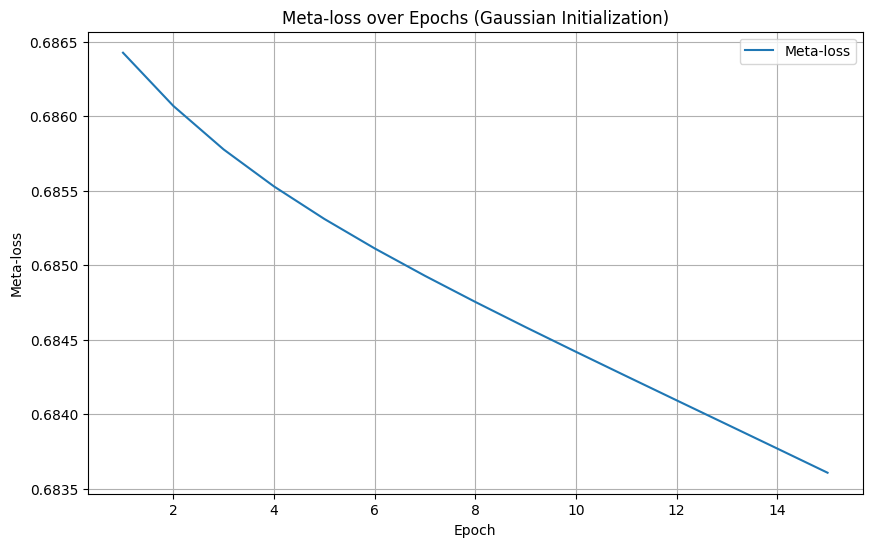

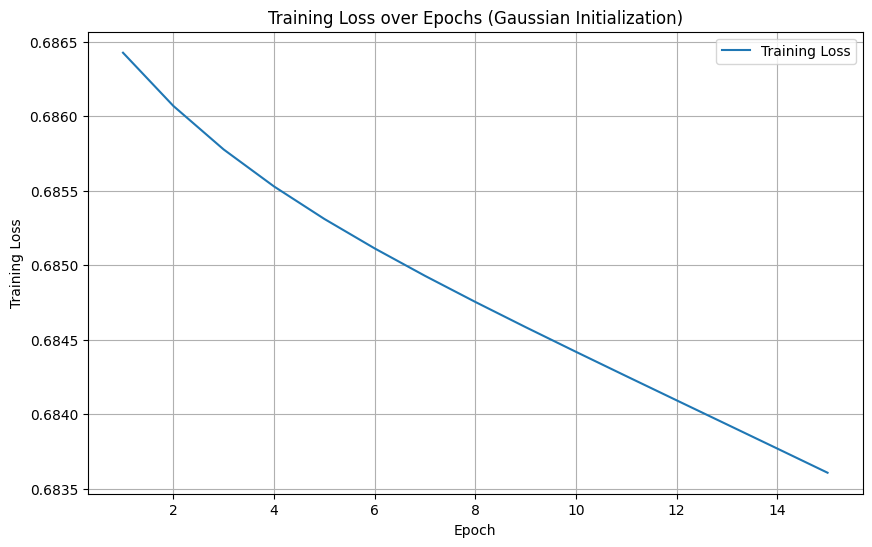

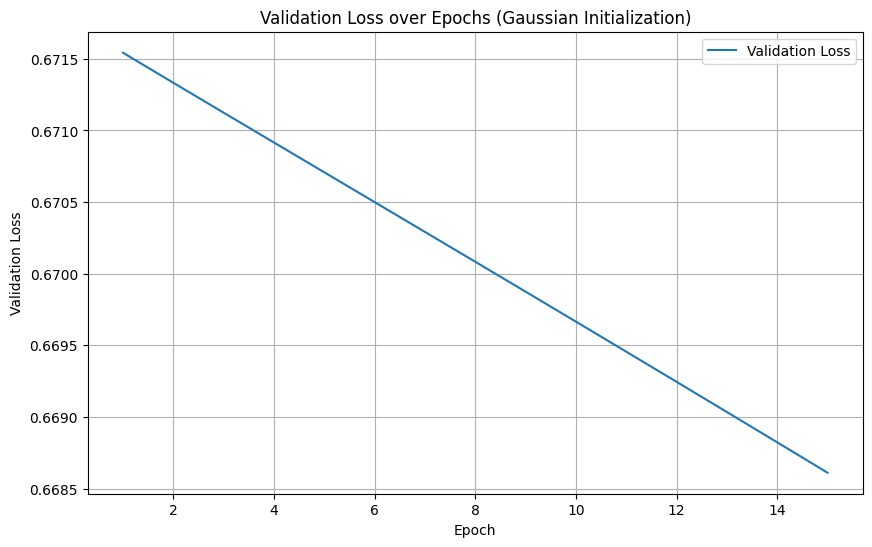

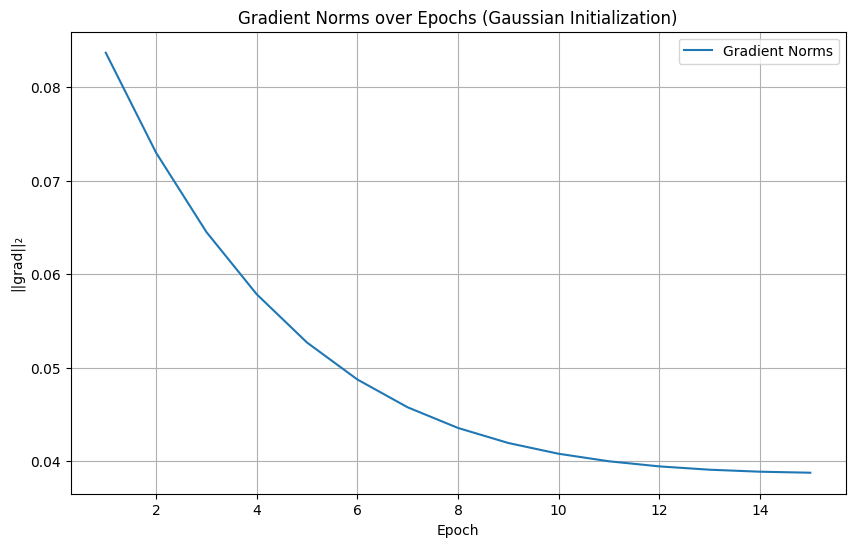

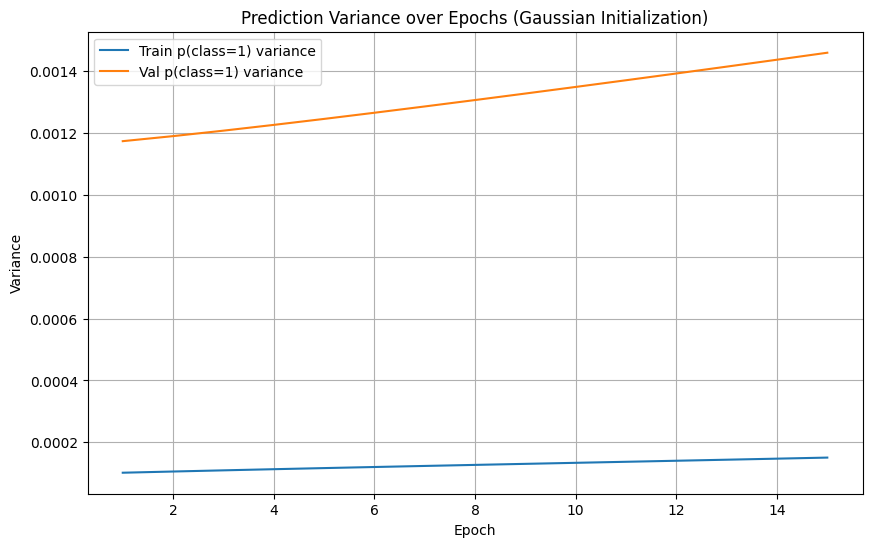

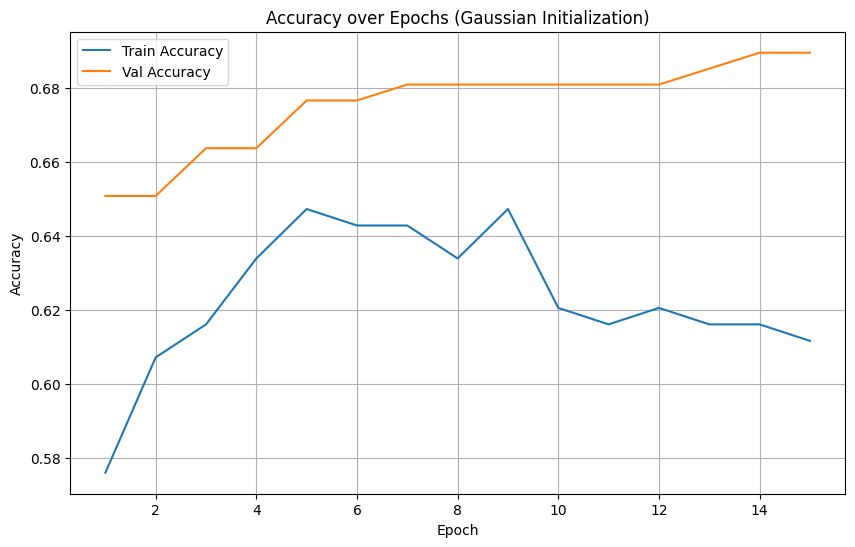


=== Testing initialization: uniform ===
[PQC] Using lightning.qubit + adjoint


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[Probe 7A] uniform  grad||pqc.weights: 0.11118684644991868  grad||pqc.fc.weight: 0.10294345021247864  grad||cnn.backbone.fc[0].weight: 3.8788139820098877
[Probe 7B] uniform ||Δθ_PQC|| = 0.008279138063558825
[Probe 7C] uniform  feat mean: -0.12025193125009537  feat std: 0.3105078339576721
[Probe 7D] uniform  p1[min,mean,max]: 0.6650497913360596 0.6651246547698975 0.6652738451957703
[Reptile*] Epoch 1/15 | Meta-loss 0.6870 | Val Loss 0.6737 | Train Acc 0.5268 | Val Acc 0.6853 | Train p-var 0.0001 | Val p-var 0.0006
[Reptile*] Epoch 2/15 | Meta-loss 0.6866 | Val Loss 0.6735 | Train Acc 0.5536 | Val Acc 0.6897 | Train p-var 0.0001 | Val p-var 0.0006
[Reptile*] Epoch 3/15 | Meta-loss 0.6863 | Val Loss 0.6734 | Train Acc 0.5893 | Val Acc 0.6897 | Train p-var 0.0001 | Val p-var 0.0006
[Reptile*] Epoch 4/15 | Meta-loss 0.6861 | Val Loss 0.6732 | Train Acc 0.6161 | Val Acc 0.6810 | Train p-var 0.0001 | Val p-var 0.0006
[Reptile*] Epoch 5/15 | Meta-loss 0.6859 | Val Loss 0.6730 | Train Acc 0.611

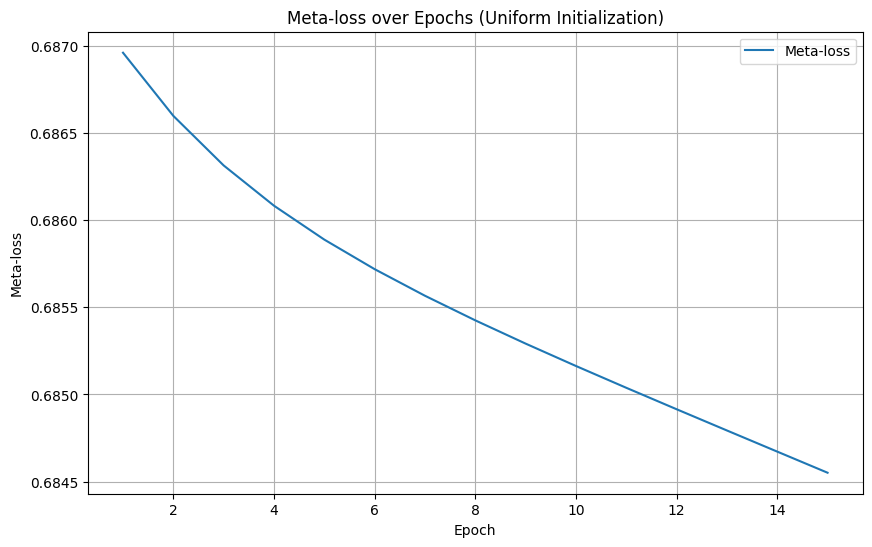

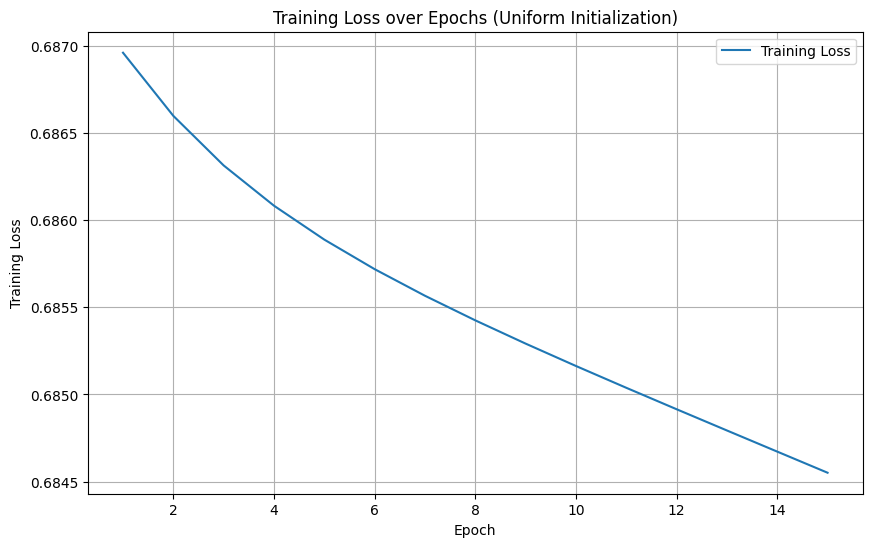

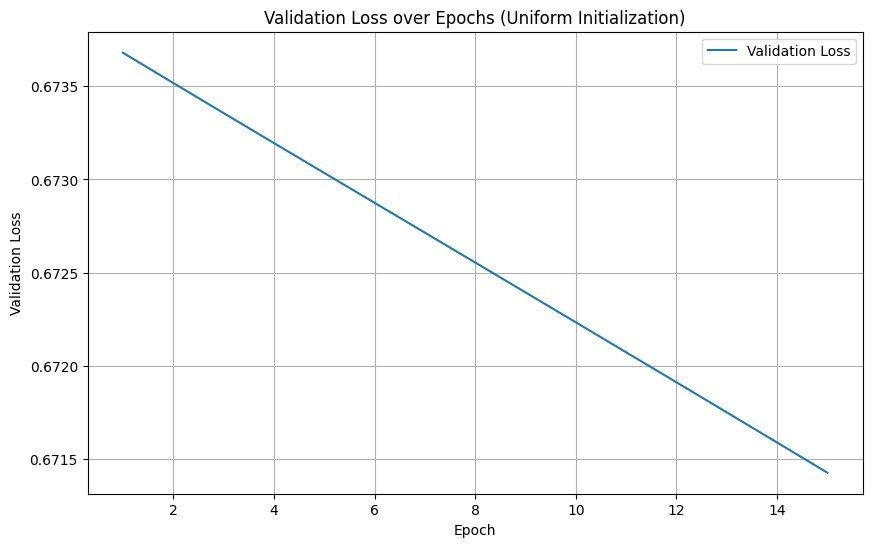

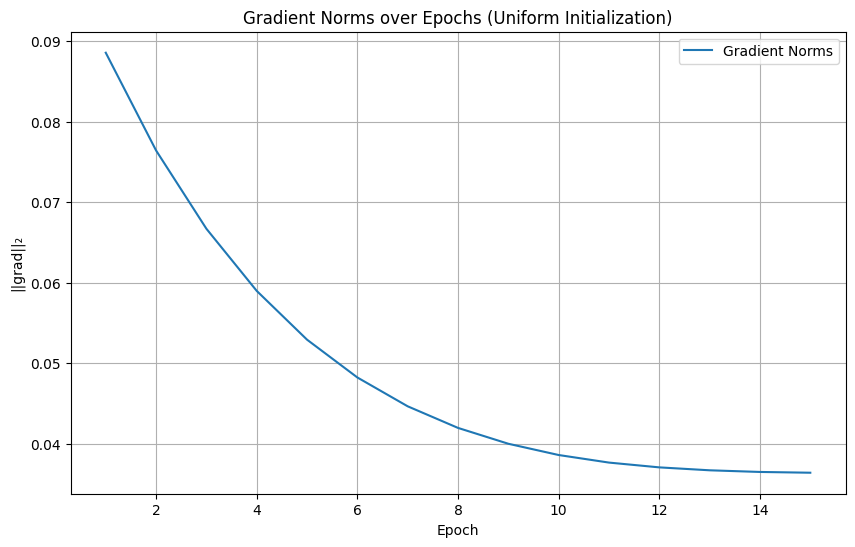

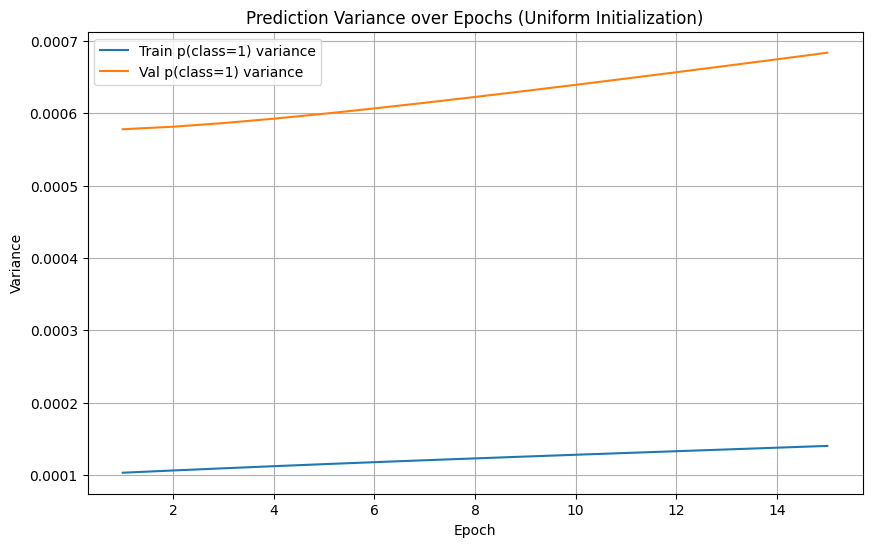

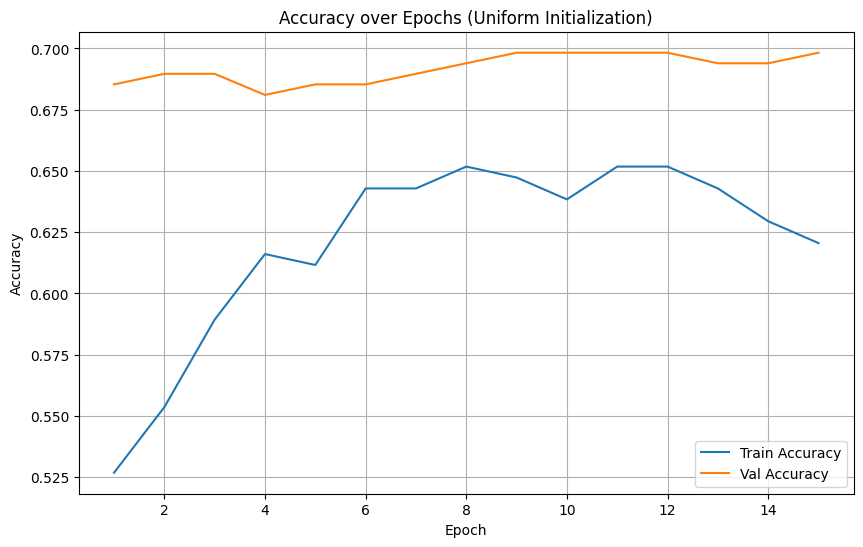


=== Testing initialization: qmaml_learner ===
[PQC] Using lightning.qubit + adjoint


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[Probe 7A] qmaml_learner  grad||pqc.weights: 0.1002825364313807  grad||pqc.fc.weight: 0.2874397039413452  grad||cnn.backbone.fc[0].weight: 5.612258434295654
[Probe 7B] qmaml_learner ||Δθ_PQC|| = 0.005428940300467208
[Probe 7C] qmaml_learner  feat mean: -0.12025193125009537  feat std: 0.3105078339576721
[Probe 7D] qmaml_learner  p1[min,mean,max]: 0.6012475490570068 0.6014246344566345 0.6016706228256226
[Sanity] trainable params:
  learner: 137496
  pqc.fc : 10
  cnn.to_angles: 2052
  cnn.layer4: 8388608
[Q-MAML] Epoch 1/15 | Meta-loss 0.6876 | Val Loss 0.6730 | Train Acc 0.6116 | Val Acc 0.7500 | Train p-var 0.0002 | Val p-var 0.0003
[Q-MAML] Epoch 2/15 | Meta-loss 0.6683 | Val Loss 0.6527 | Train Acc 0.7232 | Val Acc 0.7672 | Train p-var 0.0011 | Val p-var 0.0013
[Q-MAML] Epoch 3/15 | Meta-loss 0.6526 | Val Loss 0.6371 | Train Acc 0.7054 | Val Acc 0.7586 | Train p-var 0.0027 | Val p-var 0.0026
[Q-MAML] Epoch 4/15 | Meta-loss 0.6401 | Val Loss 0.6280 | Train Acc 0.6920 | Val Acc 0.6466 

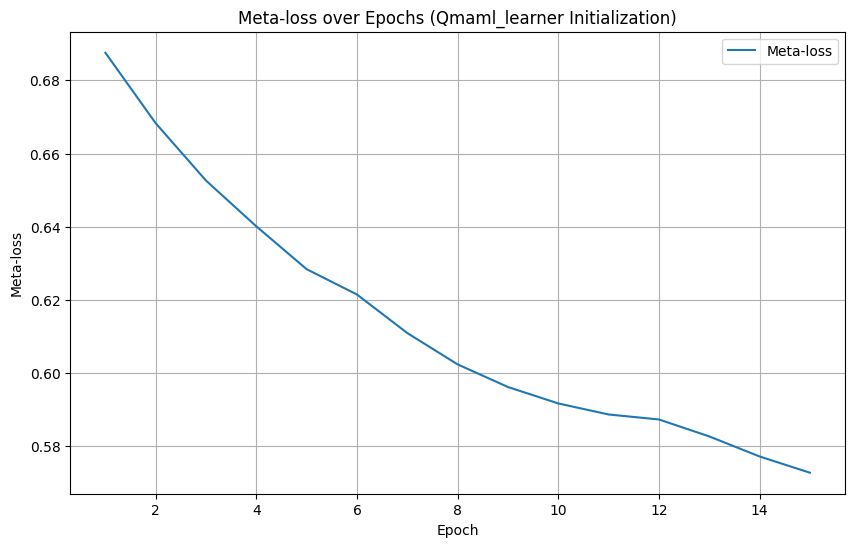

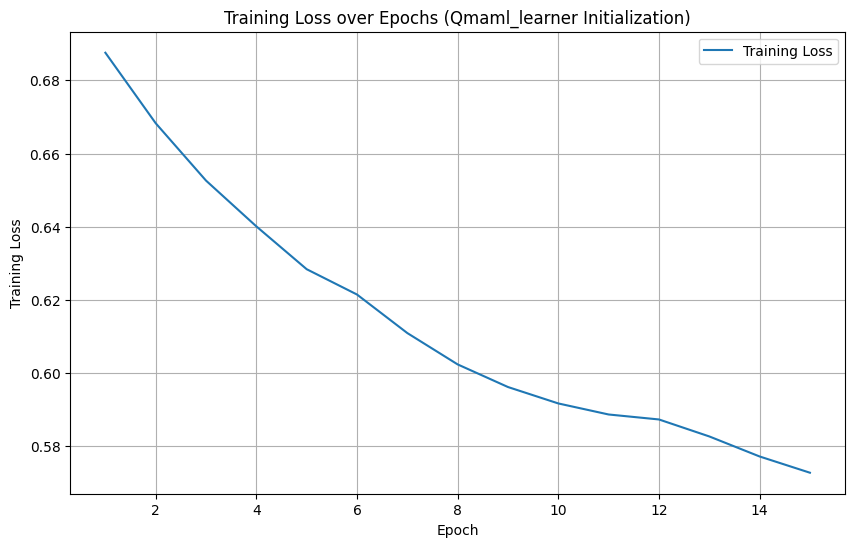

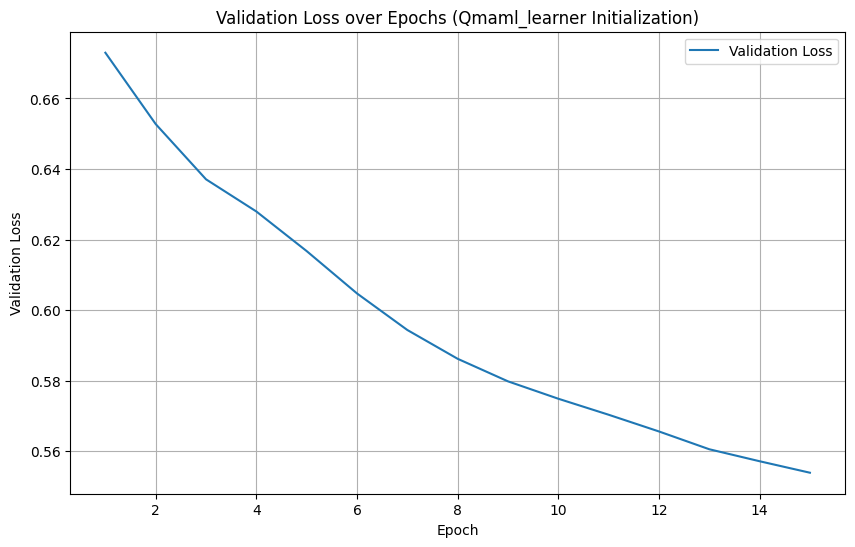

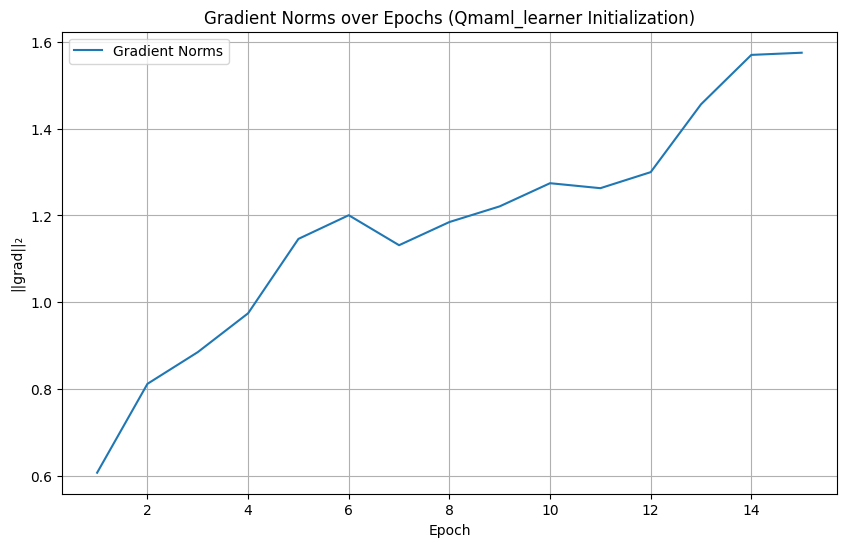

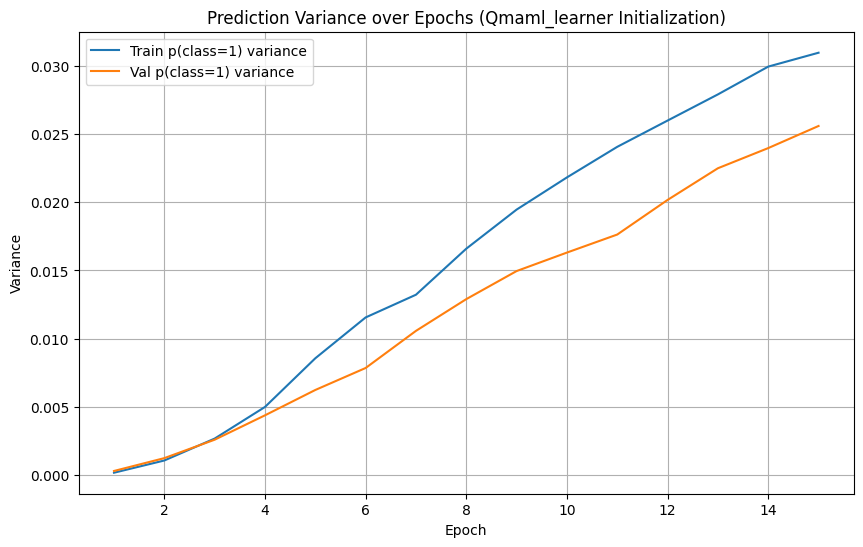

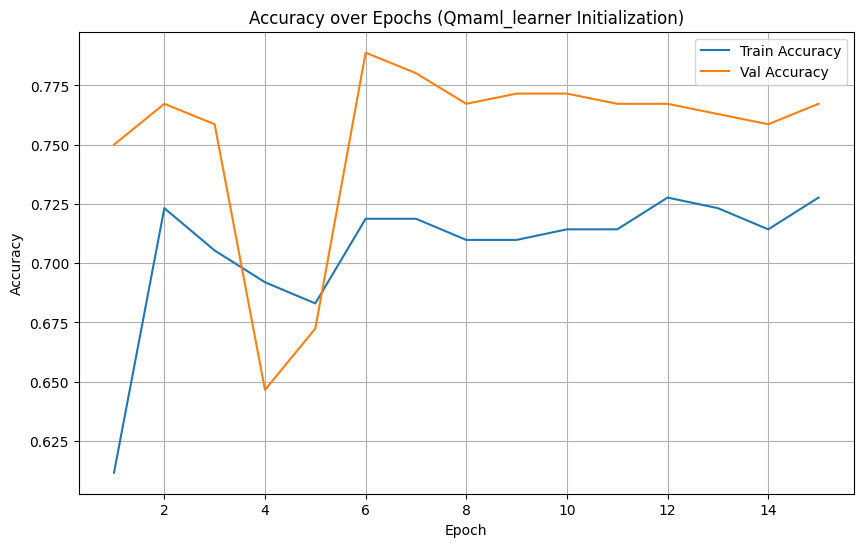


=== Testing initialization: zero ===
[PQC] Using lightning.qubit + adjoint


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[Probe 7A] zero  grad||pqc.weights: 0.1002825364313807  grad||pqc.fc.weight: 0.2874397039413452  grad||cnn.backbone.fc[0].weight: 5.612258434295654
[Probe 7B] zero ||Δθ_PQC|| = 0.005428940300467208
[Probe 7C] zero  feat mean: -0.12025193125009537  feat std: 0.3105078339576721
[Probe 7D] zero  p1[min,mean,max]: 0.6012475490570068 0.6014246344566345 0.6016706228256226
[Reptile*] Epoch 1/15 | Meta-loss 0.6924 | Val Loss 0.6816 | Train Acc 0.5045 | Val Acc 0.6552 | Train p-var 0.0001 | Val p-var 0.0002
[Reptile*] Epoch 2/15 | Meta-loss 0.6923 | Val Loss 0.6815 | Train Acc 0.5312 | Val Acc 0.6552 | Train p-var 0.0001 | Val p-var 0.0002
[Reptile*] Epoch 3/15 | Meta-loss 0.6922 | Val Loss 0.6813 | Train Acc 0.5000 | Val Acc 0.6595 | Train p-var 0.0001 | Val p-var 0.0002
[Reptile*] Epoch 4/15 | Meta-loss 0.6920 | Val Loss 0.6812 | Train Acc 0.4955 | Val Acc 0.6595 | Train p-var 0.0001 | Val p-var 0.0002
[Reptile*] Epoch 5/15 | Meta-loss 0.6919 | Val Loss 0.6811 | Train Acc 0.5045 | Val Acc 0.6

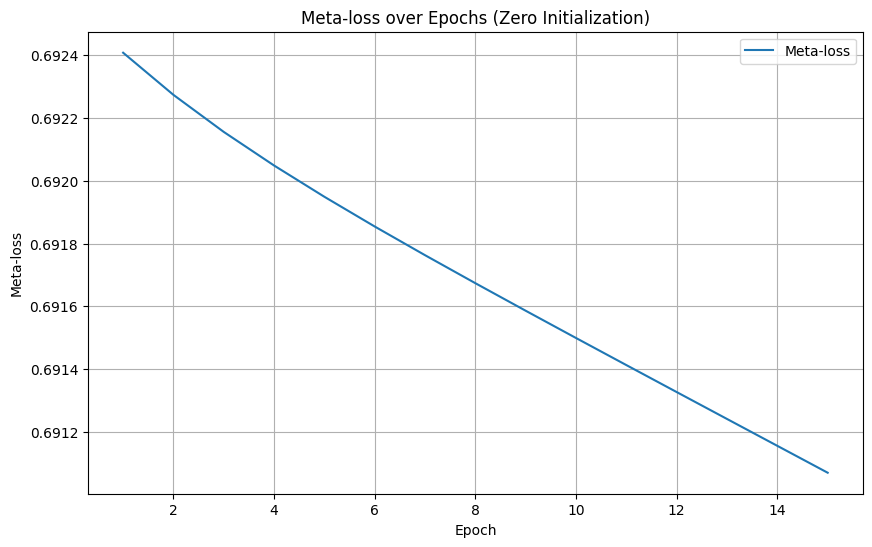

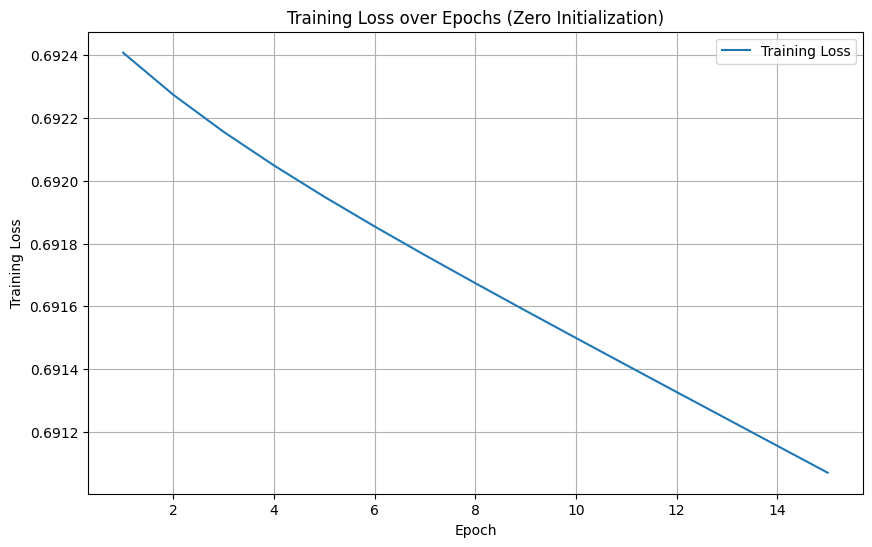

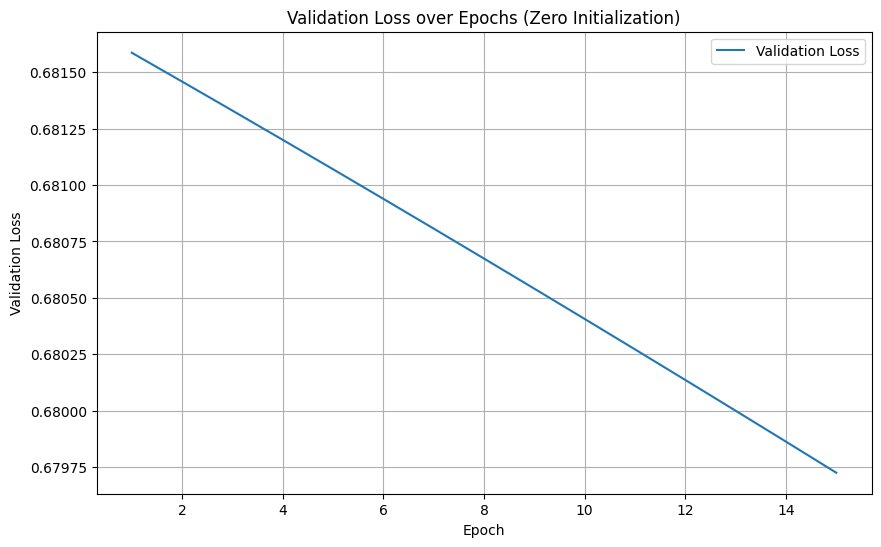

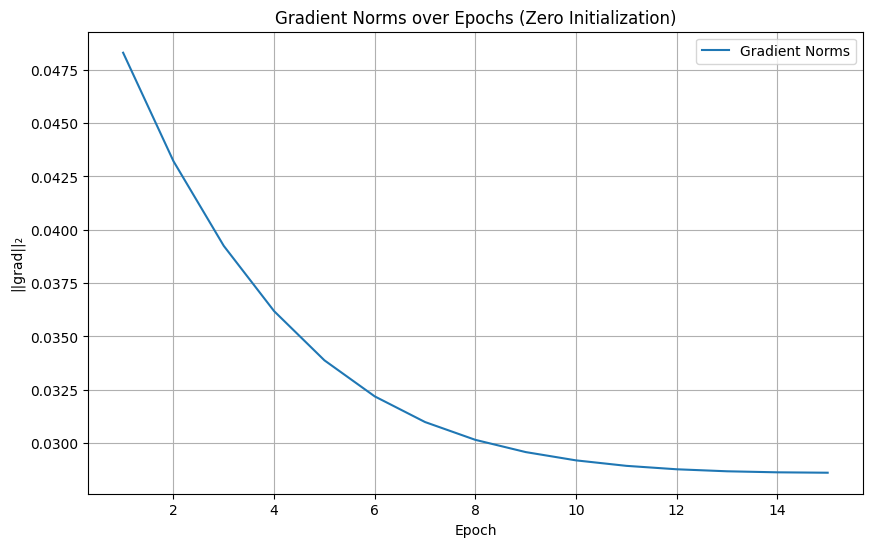

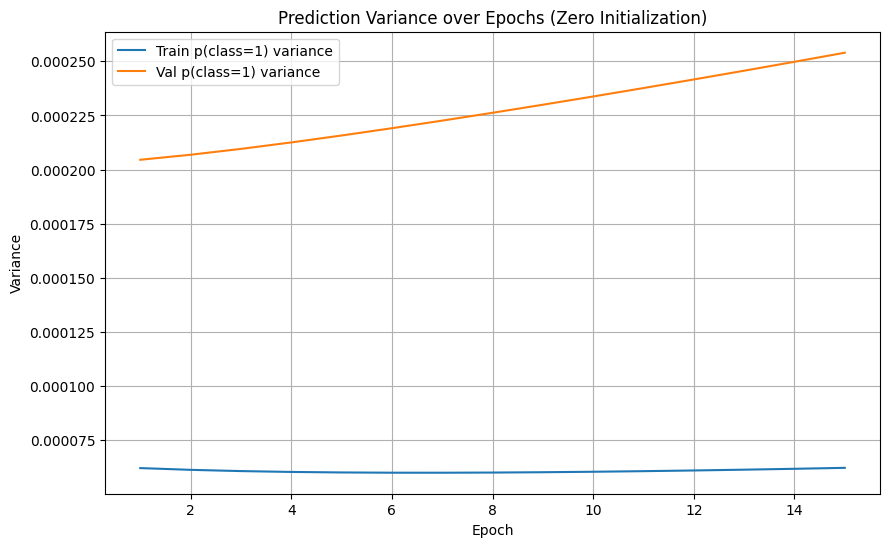

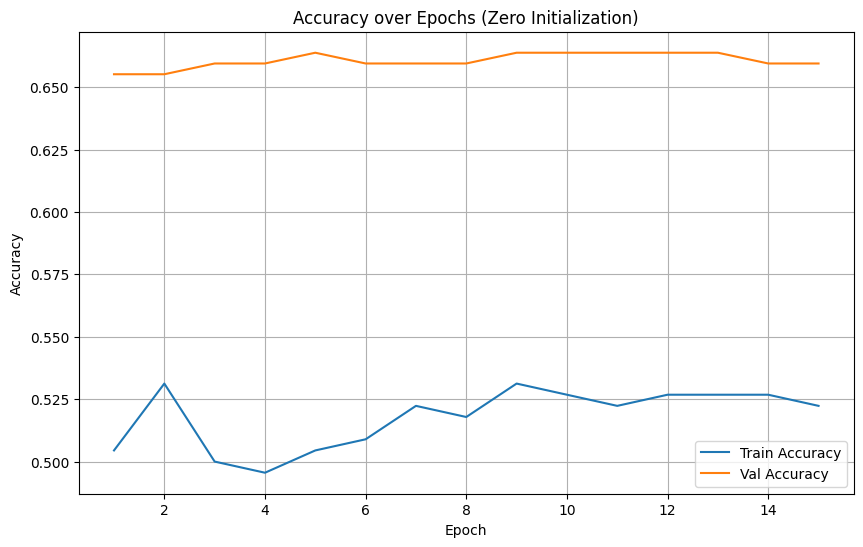


=== Testing initialization: pi ===
[PQC] Using lightning.qubit + adjoint


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[Probe 7A] pi  grad||pqc.weights: 0.026286017944817743  grad||pqc.fc.weight: 0.2689635455608368  grad||cnn.backbone.fc[0].weight: 3.1310343742370605
[Probe 7B] pi ||Δθ_PQC|| = 0.00416909276393008
[Probe 7C] pi  feat mean: -0.12025193125009537  feat std: 0.3105078339576721
[Probe 7D] pi  p1[min,mean,max]: 0.5845696926116943 0.5846936702728271 0.5849686861038208
[Reptile*] Epoch 1/15 | Meta-loss 0.6874 | Val Loss 0.6782 | Train Acc 0.5982 | Val Acc 0.6422 | Train p-var 0.0001 | Val p-var 0.0005
[Reptile*] Epoch 2/15 | Meta-loss 0.6873 | Val Loss 0.6781 | Train Acc 0.6027 | Val Acc 0.6466 | Train p-var 0.0001 | Val p-var 0.0005
[Reptile*] Epoch 3/15 | Meta-loss 0.6872 | Val Loss 0.6779 | Train Acc 0.5938 | Val Acc 0.6422 | Train p-var 0.0001 | Val p-var 0.0005
[Reptile*] Epoch 4/15 | Meta-loss 0.6871 | Val Loss 0.6778 | Train Acc 0.5982 | Val Acc 0.6466 | Train p-var 0.0001 | Val p-var 0.0005
[Reptile*] Epoch 5/15 | Meta-loss 0.6870 | Val Loss 0.6776 | Train Acc 0.5938 | Val Acc 0.6466 | 

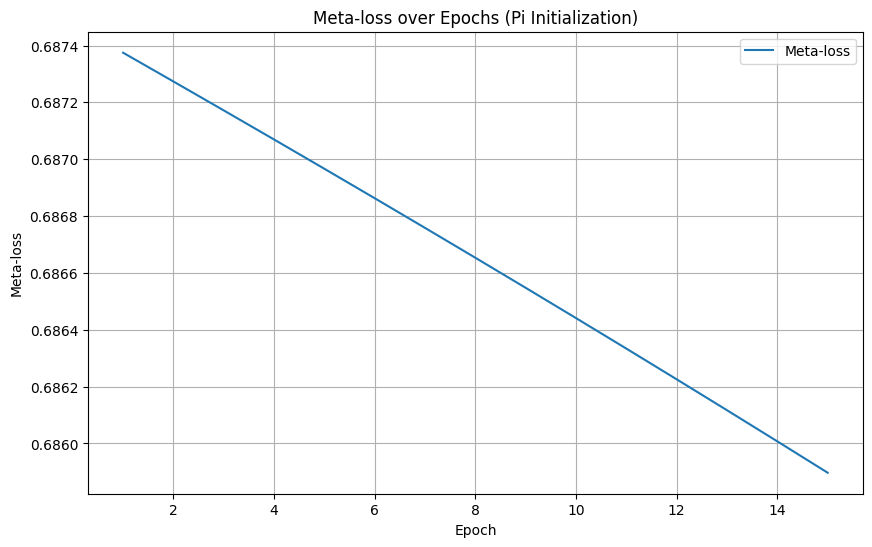

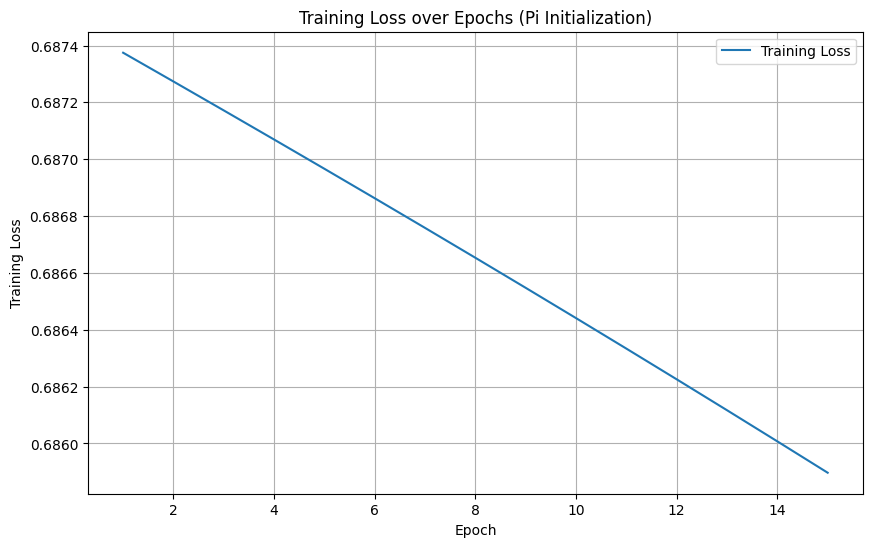

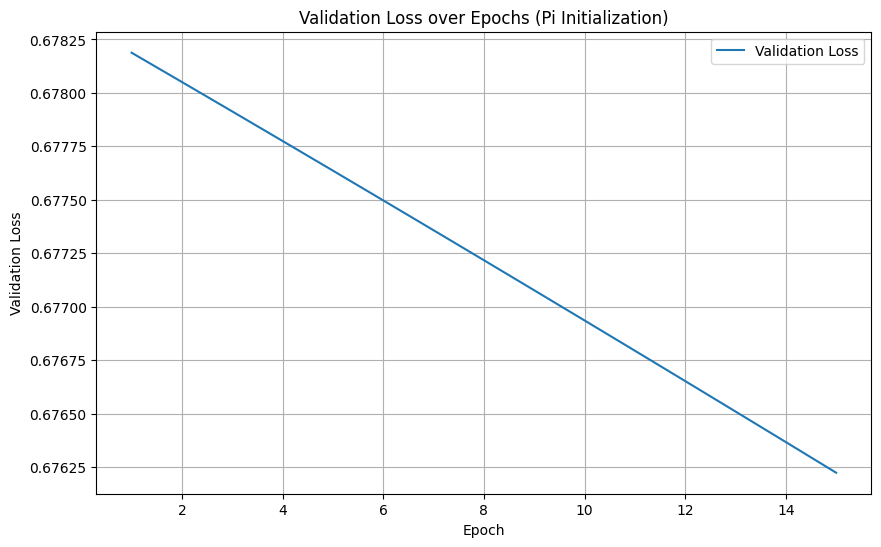

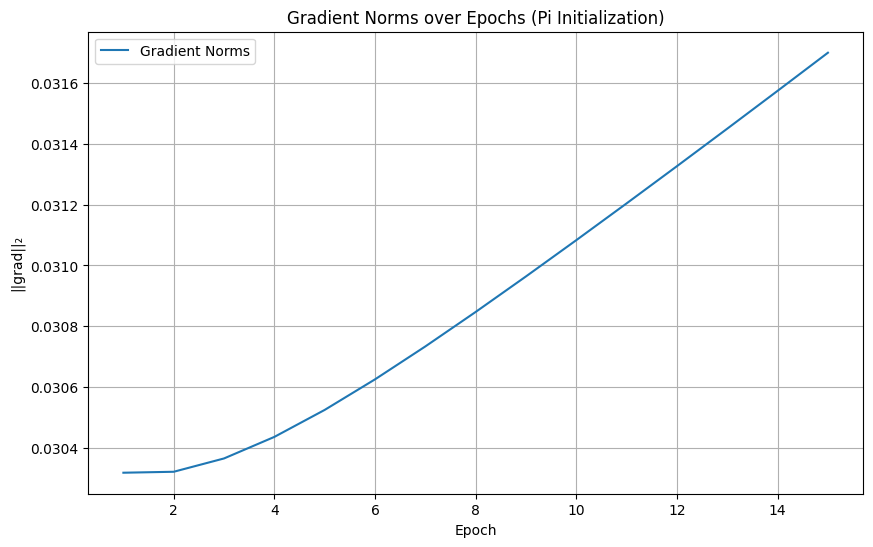

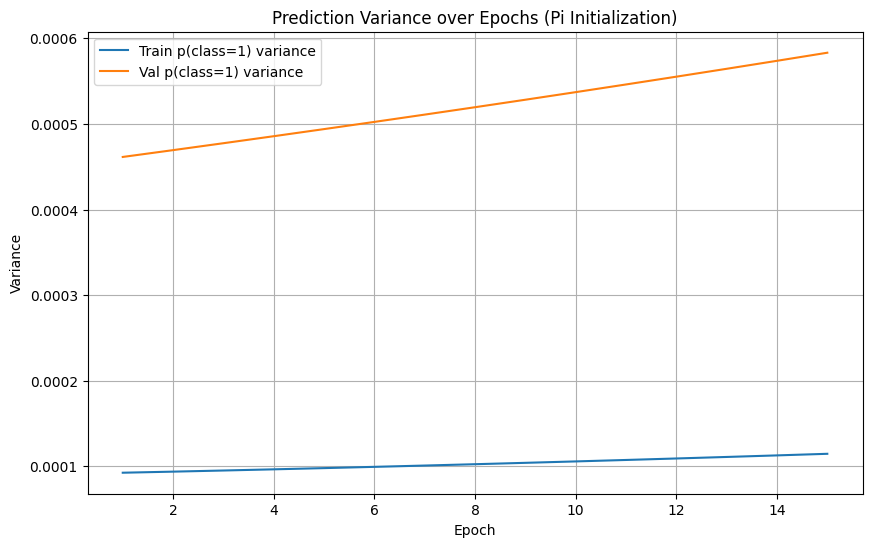

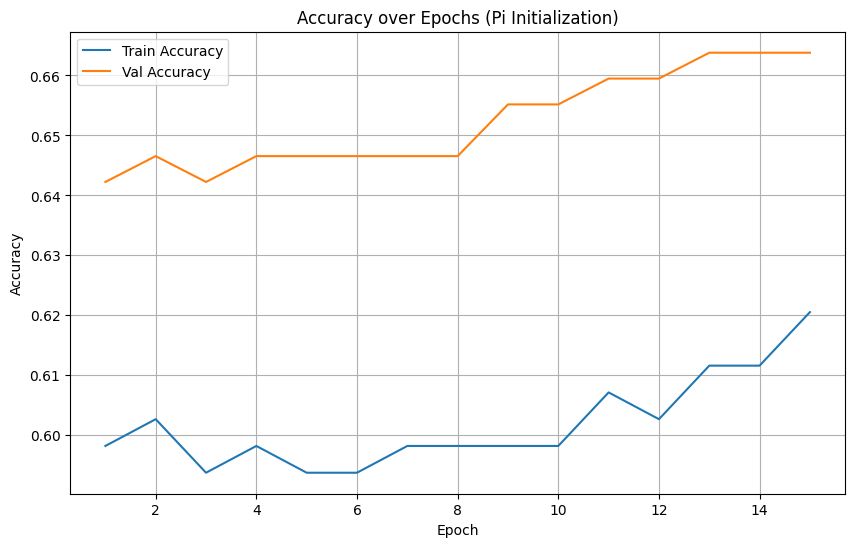

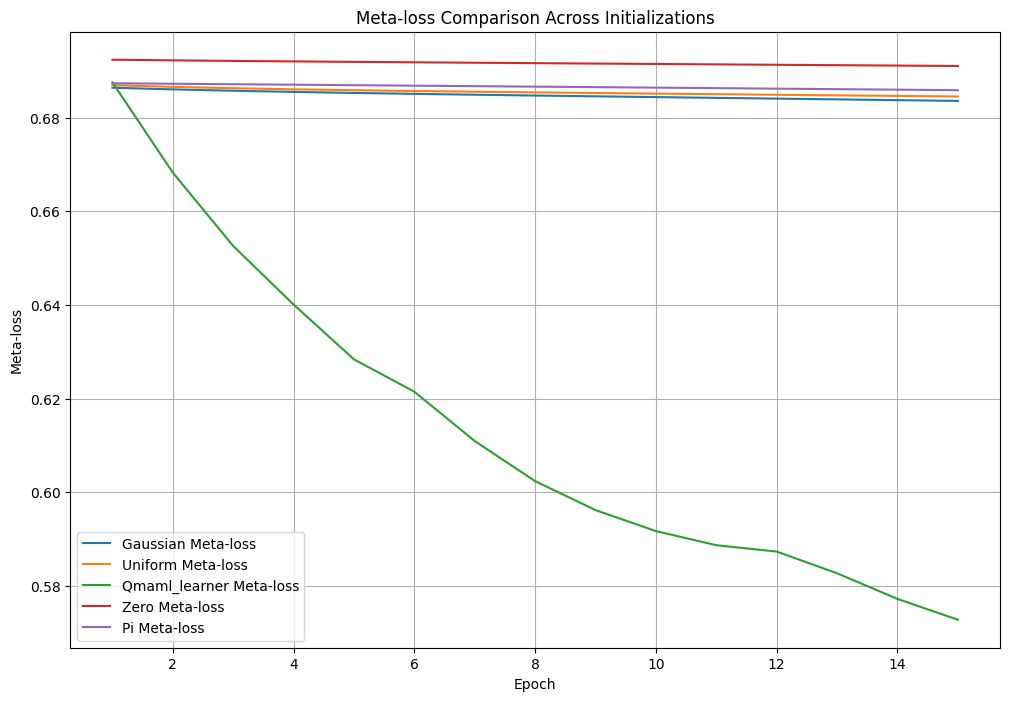

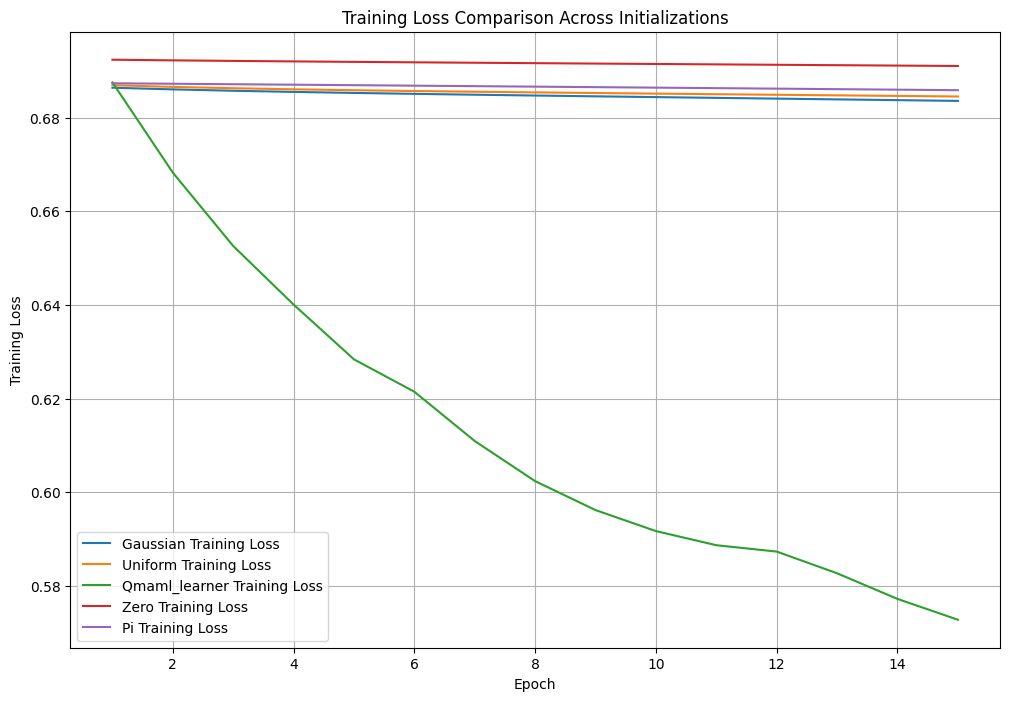

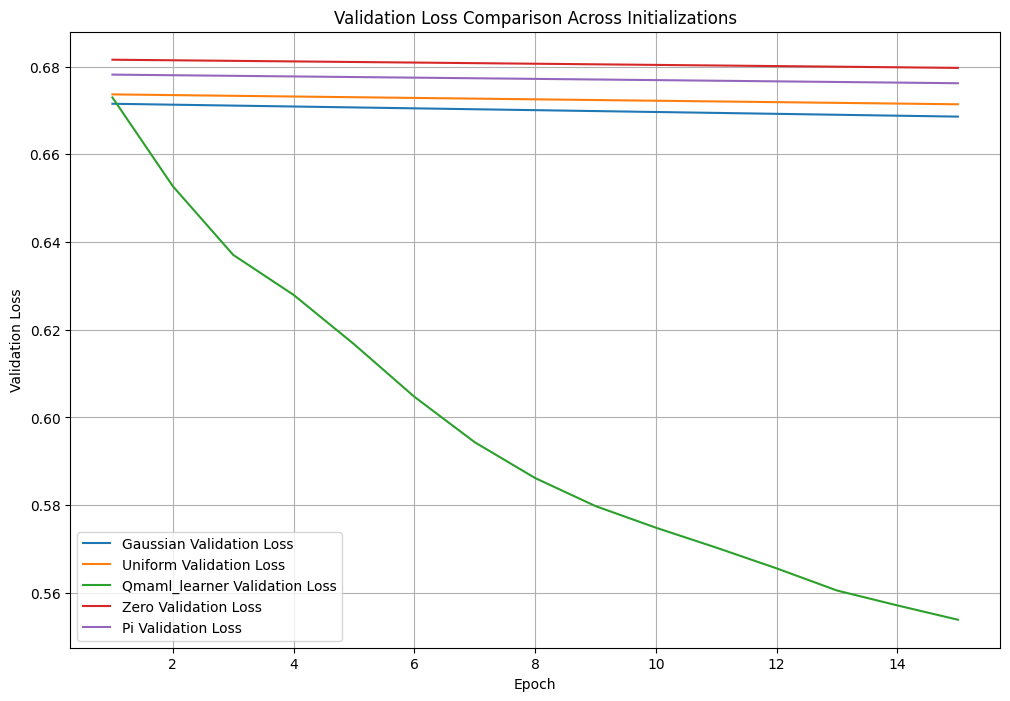

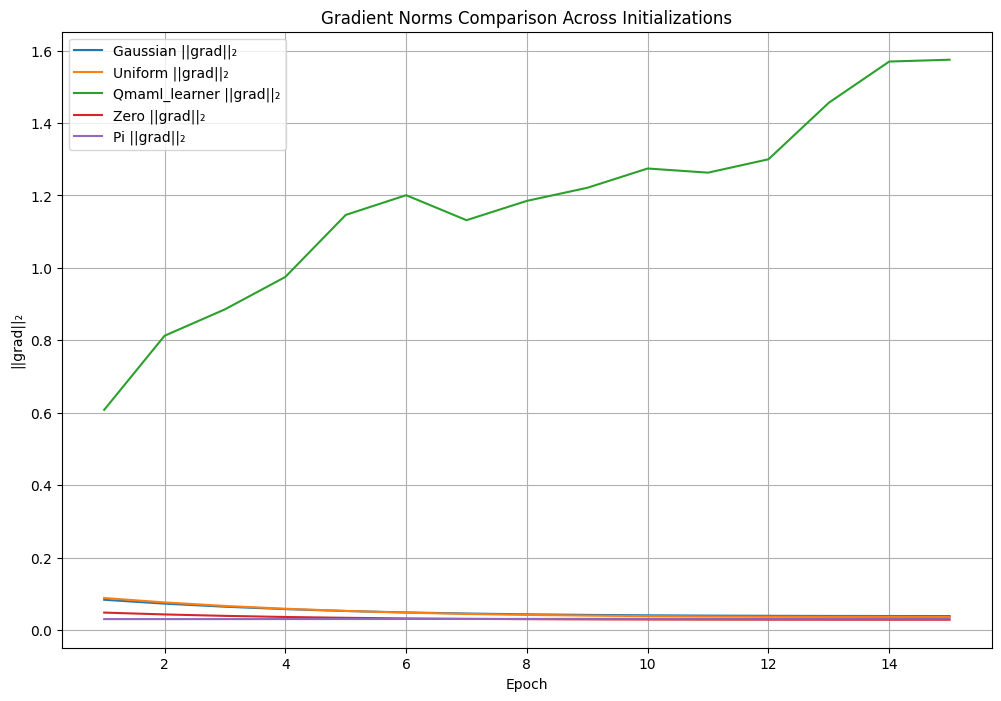

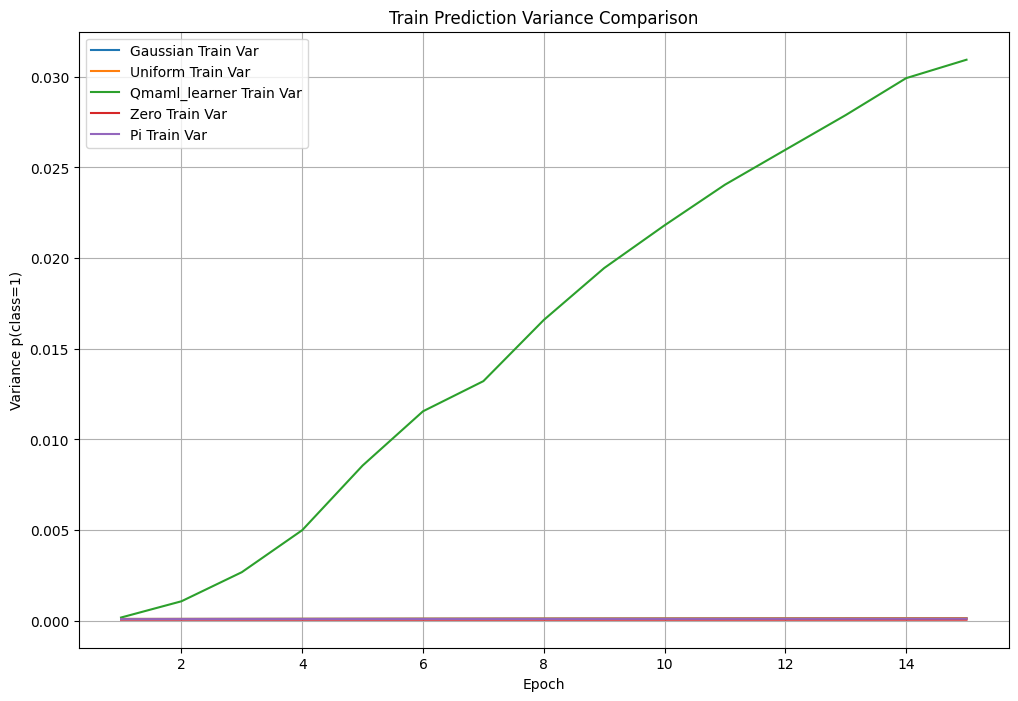

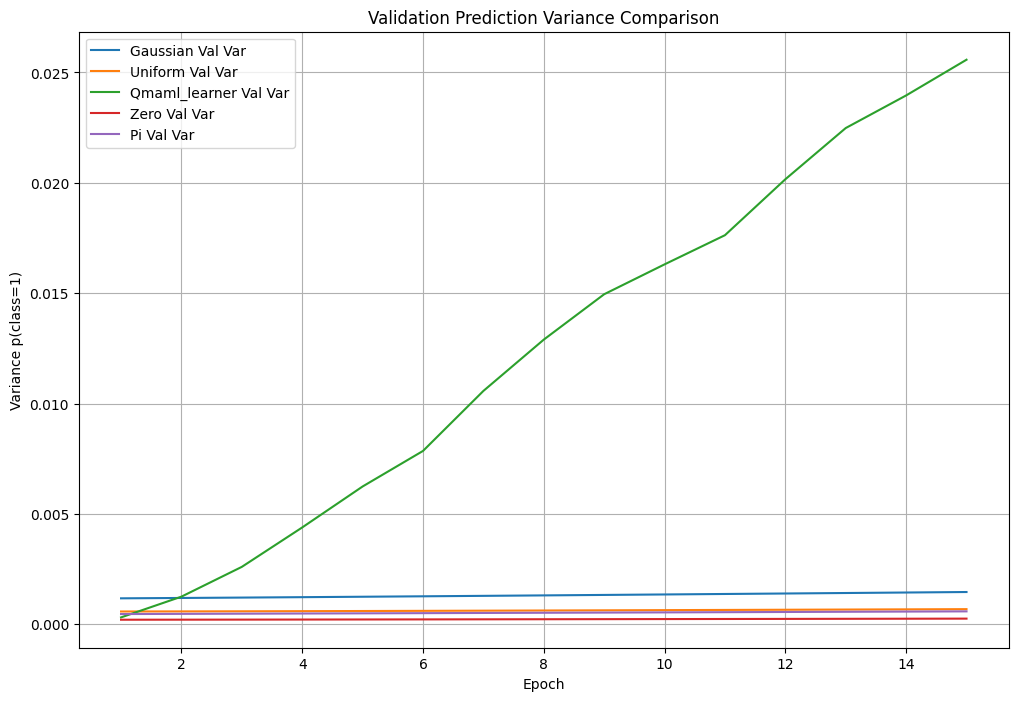

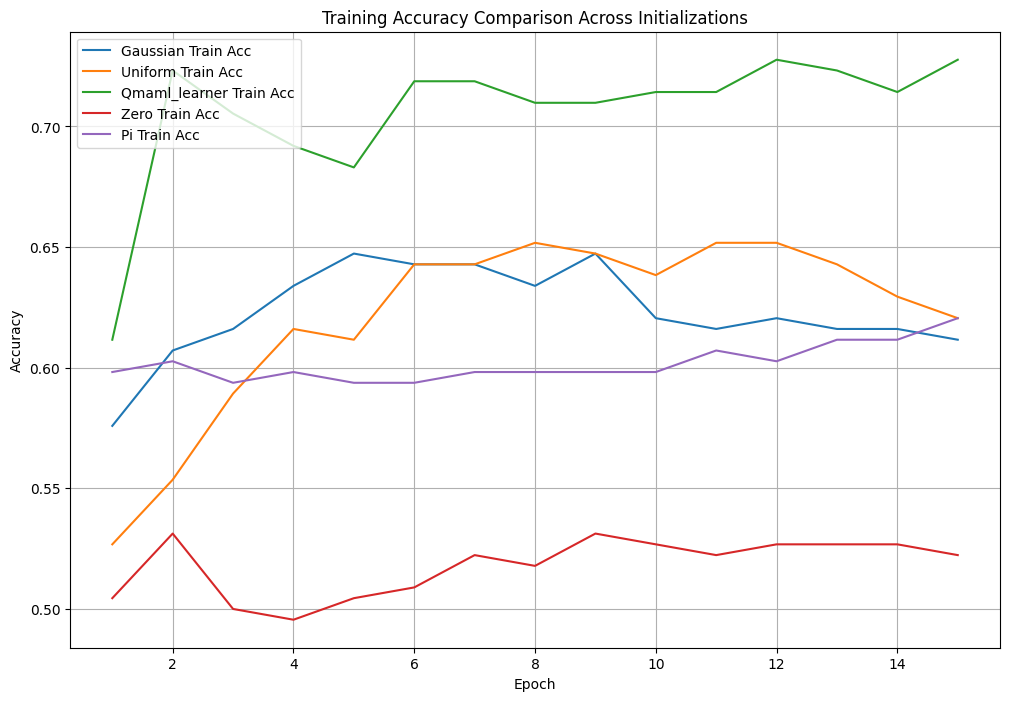

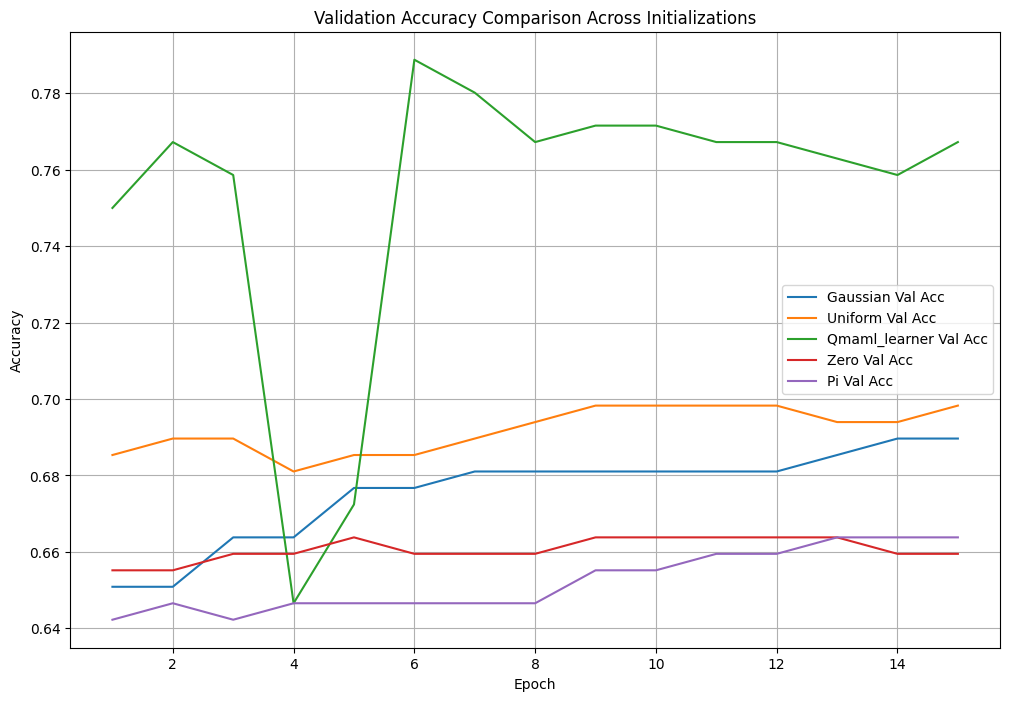

In [28]:
# --- Cell 16: Running (FIXED: add warmup for ALL inits) ---
initialization_types = ["gaussian", "uniform", "qmaml_learner", "zero", "pi",  ]
results: Dict[str, Dict[str, List[float]]] = {}

def _pqc_only_flat(pqc: nn.Module) -> torch.Tensor:
    """Flatten only the PQC parameters (stable shape across inner loop)."""
    return torch.cat([
        pqc.weights.detach().flatten().cpu(),
        pqc.fc.weight.detach().flatten().cpu(),
        pqc.fc.bias.detach().flatten().cpu(),
    ])

for init_type in initialization_types:
    print(f"\n=== Testing initialization: {init_type} ===")
    torch.manual_seed(42); np.random.seed(42)

    cnn_extractor = CNNFeatureExtractor(config.CNN_OUTPUT_DIM, config.NUM_QUBITS)
    # Keep BN frozen/eval
    freeze_bn(cnn_extractor)

    pqc_init = "zero" if init_type == "qmaml_learner" else init_type
    pqc_model = PQCModel(
        config.NUM_QUBITS,
        config.Q_DEPTH,
        init_type=pqc_init,
        bound_angles=True,
        verbose=True
    )
    hybrid_model = HybridModel(cnn_extractor, pqc_model)

    # Prepare small probe batches
    _sx = meta_tasks[0]["support_X"][:8]
    _sy = meta_tasks[0]["support_y"][:8]
    _qx = meta_tasks[0]["query_X"]

    # ---- 7A) Gradient flow probe ----
    for p in hybrid_model.parameters():
        if p.grad is not None:
            p.grad.zero_()
    _loss = nn.CrossEntropyLoss()(hybrid_model(_sx), _sy)
    _loss.backward()
    def _gnorm(p): return None if (p.grad is None) else float(p.grad.norm().item())
    try:
        _cnn_fc0 = cnn_extractor.backbone.fc[0].weight
        print("[Probe 7A]", init_type,
              " grad||pqc.weights:", _gnorm(pqc_model.weights),
              " grad||pqc.fc.weight:", _gnorm(pqc_model.fc.weight),
              " grad||cnn.backbone.fc[0].weight:", _gnorm(_cnn_fc0))
    except Exception:
        print("[Probe 7A]", init_type,
              " grad||pqc.weights:", _gnorm(pqc_model.weights),
              " grad||pqc.fc.weight:", _gnorm(pqc_model.fc.weight))

    # ---- 7B) inner loop test (PQC-only) ----
    w_before = _pqc_only_flat(pqc_model)
    _ = inner_loop_adaptation(
        hybrid_model,
        meta_tasks[0]["support_X"], meta_tasks[0]["support_y"],
        inner_steps=2, inner_lr=0.01
    )
    w_after = _pqc_only_flat(pqc_model)
    print("[Probe 7B]", init_type, "||Δθ_PQC|| =", torch.norm(w_after - w_before).item())

    # ---- 7C) CNN feature stats ----
    with torch.no_grad():
        _f = cnn_extractor(meta_tasks[0]["support_X"])
    print("[Probe 7C]", init_type, " feat mean:", _f.mean().item(), " feat std:", _f.std().item())

    # ---- 7D) Prediction distribution on a query mini-batch ----
    with torch.no_grad():
        _p = torch.softmax(hybrid_model(_qx[:16]), dim=1)[:, 1]
    print("[Probe 7D]", init_type, " p1[min,mean,max]:",
          _p.min().item(), _p.mean().item(), _p.max().item())

    # ---- Warm up PQC head for ALL initialization types ----
    warmup_pqc_head(hybrid_model, meta_tasks, steps=100, lr=1e-2)

    # ---- Train per init type ----
    if init_type == "qmaml_learner":
        training_results = outer_loop_qmaml(
            hybrid_model,
            meta_tasks,
            test_meta_tasks,
            config.OUTER_LR,
            config.EVAL_METRICS,
            ckpt_name="best_qmaml_learner.pth",
        )
    else:
        training_results = outer_loop_meta_update(
            hybrid_model,
            meta_tasks,
            test_meta_tasks,
            config.OUTER_LR,
            config.EVAL_METRICS,
            ckpt_name=f"best_{init_type}.pth",
        )

    results[init_type] = training_results
    plot_training_results(training_results, init_type)

# Combined comparison plots
plot_comparison(results)
